# Finance Analytics Course - Project 2 - Group 4 - Jad, Karl, Omar, Tarek

# Importing libraries and tools

In [1]:
# Import potential libraries and tools to be used

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import category_encoders as ce
from category_encoders import TargetEncoder
from datetime import datetime
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Reading the csv file

In [2]:
# Use pd.read_csv

df0 = pd.read_csv("datico.csv")

# To ensure the display of all columns in subsequent codes
pd.set_option('display.max_columns', None)

# Adjustment of data types and Reduction of Memory Usage

In [3]:
# Create new dataframe to adjust data types and reduce memory usage

df1 = df0.copy()

# Display memory usage and data types before optimization
print("Memory usage before optimization:")
print(df0.memory_usage(deep=True).sum() / 1024**2, "MB")

#Convert date columns that are objects into dates
df1['issue_d'] = pd.to_datetime(df1['issue_d'], format='%d-%m-%Y') #issue_d column
df1['earliest_cr_line'] = pd.to_datetime(df1['earliest_cr_line'], format='%d-%m-%Y') #earliest_cr_line column
df1['last_pymnt_d'] = pd.to_datetime(df1['last_pymnt_d'], format='%d-%m-%Y') #last_pymnt_d column
df1['next_pymnt_d'] = pd.to_datetime(df1['next_pymnt_d'], format='%d-%m-%Y') #next_pymnt_d column
df1['last_credit_pull_d'] = pd.to_datetime(df1['last_credit_pull_d'], format='%d-%m-%Y') #last_credit_pull_d column

# Convert integer columns to the smallest possible int type
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].apply(pd.to_numeric, downcast='integer')

# Convert float columns to the smallest possible float type
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].apply(pd.to_numeric, downcast='float')

# Convert object columns with few unique values to category type
obj_cols = df1.select_dtypes(include=['object']).columns
for col in obj_cols:
    num_unique_values = len(df1[col].unique())
    num_total_values = len(df1[col])
    if num_unique_values / num_total_values < 0.5:
        df1[col] = df1[col].astype('category')

# Display memory usage and data types after optimization
print("Memory usage after optimization:")
print(df1.memory_usage(deep=True).sum() / 1024**2, "MB")

Memory usage before optimization:
129.9664487838745 MB
Memory usage after optimization:
31.59184455871582 MB


In [4]:
# Missing values per column
null_counts = df1.isnull().sum()
print("Columns with null values:\n")
print(null_counts[null_counts > 0])

# Calculate the percentage of null values in each column
null_percentage = df1.isnull().mean() * 100

# Identify columns with more than 75% null values
columns_to_drop_null = null_percentage[null_percentage >= 75].index

# Identify columns with only one unique value
columns_to_drop_unique = [col for col in df1.columns if df1[col].nunique() == 1]

# Combine the two sets of columns to drop
columns_to_drop = set(columns_to_drop_null).union(set(columns_to_drop_unique))

# Drop these columns from the DataFrame and store the result in df2
df2 = df1.drop(columns=columns_to_drop)

# Display the remaining columns in df2
print("Remaining columns after dropping those with more than 75% null values and only one unique value:")
print(df2.columns)


Columns with null values:

emp_title                       4949
emp_length                      4314
desc                           73622
title                              3
mths_since_last_delinq         43991
mths_since_last_record         72608
revol_util                        43
last_pymnt_d                     894
next_pymnt_d                   25192
last_credit_pull_d                 3
collections_12_mths_ex_med         3
mths_since_last_major_derog    64406
annual_inc_joint               85563
dti_joint                      85563
verification_status_joint      85563
tot_coll_amt                    6581
tot_cur_bal                     6581
open_acc_6m                    84224
open_il_6m                     84224
open_il_12m                    84224
open_il_24m                    84224
mths_since_rcnt_il             84255
total_bal_il                   84224
il_util                        84403
open_rv_12m                    84224
open_rv_24m                    84224
max_bal_bc 

In [5]:
# Missing values per column
null_counts = df2.isnull().sum()
print("Columns with null values:\n")
print(null_counts[null_counts > 0])

Columns with null values:

emp_title                      4949
emp_length                     4314
title                             3
mths_since_last_delinq        43991
revol_util                       43
last_pymnt_d                    894
next_pymnt_d                  25192
last_credit_pull_d                3
collections_12_mths_ex_med        3
tot_coll_amt                   6581
tot_cur_bal                    6581
total_rev_hi_lim               6581
dtype: int64


In [6]:
# Drop 'id' and 'member_id' from the correlation matrix calculation
df2_no_ids = df2.drop(columns=['id', 'member_id'])
df3 = df2_no_ids
df4 = df3

In [7]:
# List of columns to drop
columns_to_drop = ['emp_title', 'title', 'zip_code', 'earliest_cr_line', 'next_pymnt_d',
                  'issue_d','last_pymnt_d','last_credit_pull_d']

# Create df5 by dropping the specified columns
df5 = df4.drop(columns=columns_to_drop)

In [8]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85597 entries, 0 to 85596
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   loan_amnt                   85597 non-null  int32   
 1   funded_amnt                 85597 non-null  int32   
 2   funded_amnt_inv             85597 non-null  float64 
 3   term                        85597 non-null  category
 4   int_rate                    85597 non-null  float32 
 5   installment                 85597 non-null  float32 
 6   grade                       85597 non-null  category
 7   sub_grade                   85597 non-null  category
 8   emp_length                  81283 non-null  category
 9   home_ownership              85597 non-null  category
 10  annual_inc                  85597 non-null  float64 
 11  verification_status         85597 non-null  category
 12  purpose                     85597 non-null  category
 13  addr_state      

In [9]:
df5.shape

(85597, 41)

# Logistic Regression Model Using Top Features with LabelEncoder

C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


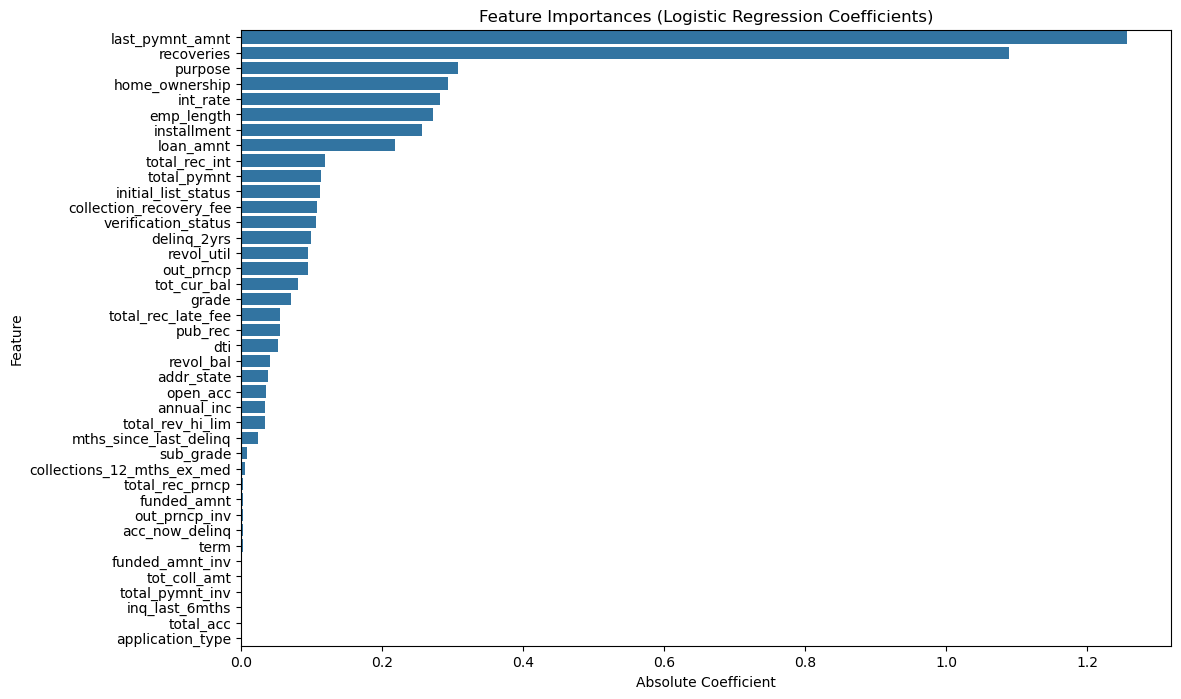


Training Set Evaluation Metrics:
Confusion Matrix:
[[48570     0]
 [ 1328  1460]]
Accuracy: 0.974
Precision: 1.000
Recall: 0.524
F1 Score: 0.687
Specificity: 1.000
ROC AUC: 0.883
Mean Squared Error (MSE): 0.026

Test Set Evaluation Metrics:
Confusion Matrix:
[[32380     0]
 [  895   964]]
Accuracy: 0.974
Precision: 1.000
Recall: 0.519
F1 Score: 0.683
Specificity: 1.000
ROC AUC: 0.877
Mean Squared Error (MSE): 0.026


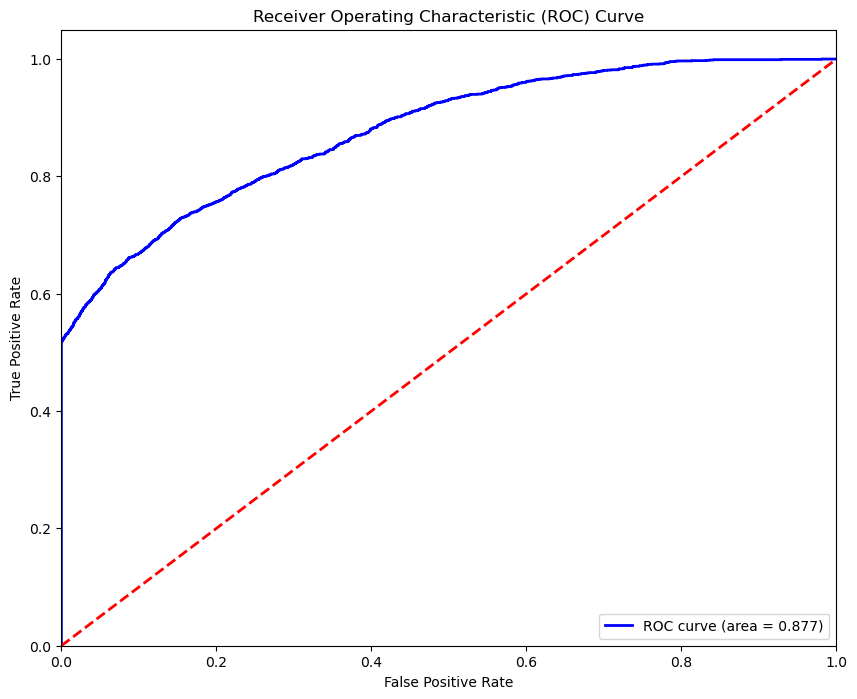


Comparison of Training and Testing Performance:
Training Accuracy: 0.974 vs Testing Accuracy: 0.974
Training Precision: 1.000 vs Testing Precision: 1.000
Training Recall: 0.524 vs Testing Recall: 0.519
Training F1 Score: 0.687 vs Testing F1 Score: 0.683
Training Specificity: 1.000 vs Testing Specificity: 1.000
Training ROC AUC: 0.883 vs Testing ROC AUC: 0.877
Training MSE: 0.026 vs Testing MSE: 0.026


In [10]:
# Encode categorical variables
df5_encoded = df5.copy()

label_encoders = {}

for column in df5_encoded.select_dtypes(include=['category']).columns:
    label_encoders[column] = LabelEncoder()
    df5_encoded[column] = label_encoders[column].fit_transform(df5_encoded[column])

# Define features and target
X = df5_encoded.drop(columns=['default_ind'])
y = df5_encoded['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Handle missing values after splitting
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Separate numerical and categorical columns
numerical_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
                  'delinq_2yrs', 'inq_last_6mths','mths_since_last_delinq', 'open_acc', 
                  'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 
                  'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
                  'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

categorical_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 
                    'purpose', 'addr_state', 'initial_list_status', 'application_type']

# Apply imputer to numerical columns
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])

# Apply imputer to categorical columns
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

# Using Robust Scaler to handle outliers
scaler = RobustScaler()

# Apply the scaler to the numerical columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Get coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for visualization
features = X_train.columns
importances_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude
importances_df['Absolute Coefficient'] = importances_df['Coefficient'].abs()
importances_df = importances_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importances_df)
plt.title('Feature Importances (Logistic Regression Coefficients)')
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train a Logistic Regression model
clf_logistic = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic.fit(X_train_top, y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_logistic.predict_proba(X_train_top)[:, 1]
y_train_pred = clf_logistic.predict(X_train_top)

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_logistic.predict_proba(X_test_top)[:, 1]
y_pred = clf_logistic.predict(X_test_top)

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Logistic Regression Model Using Top Features With OneHotEncoder

C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


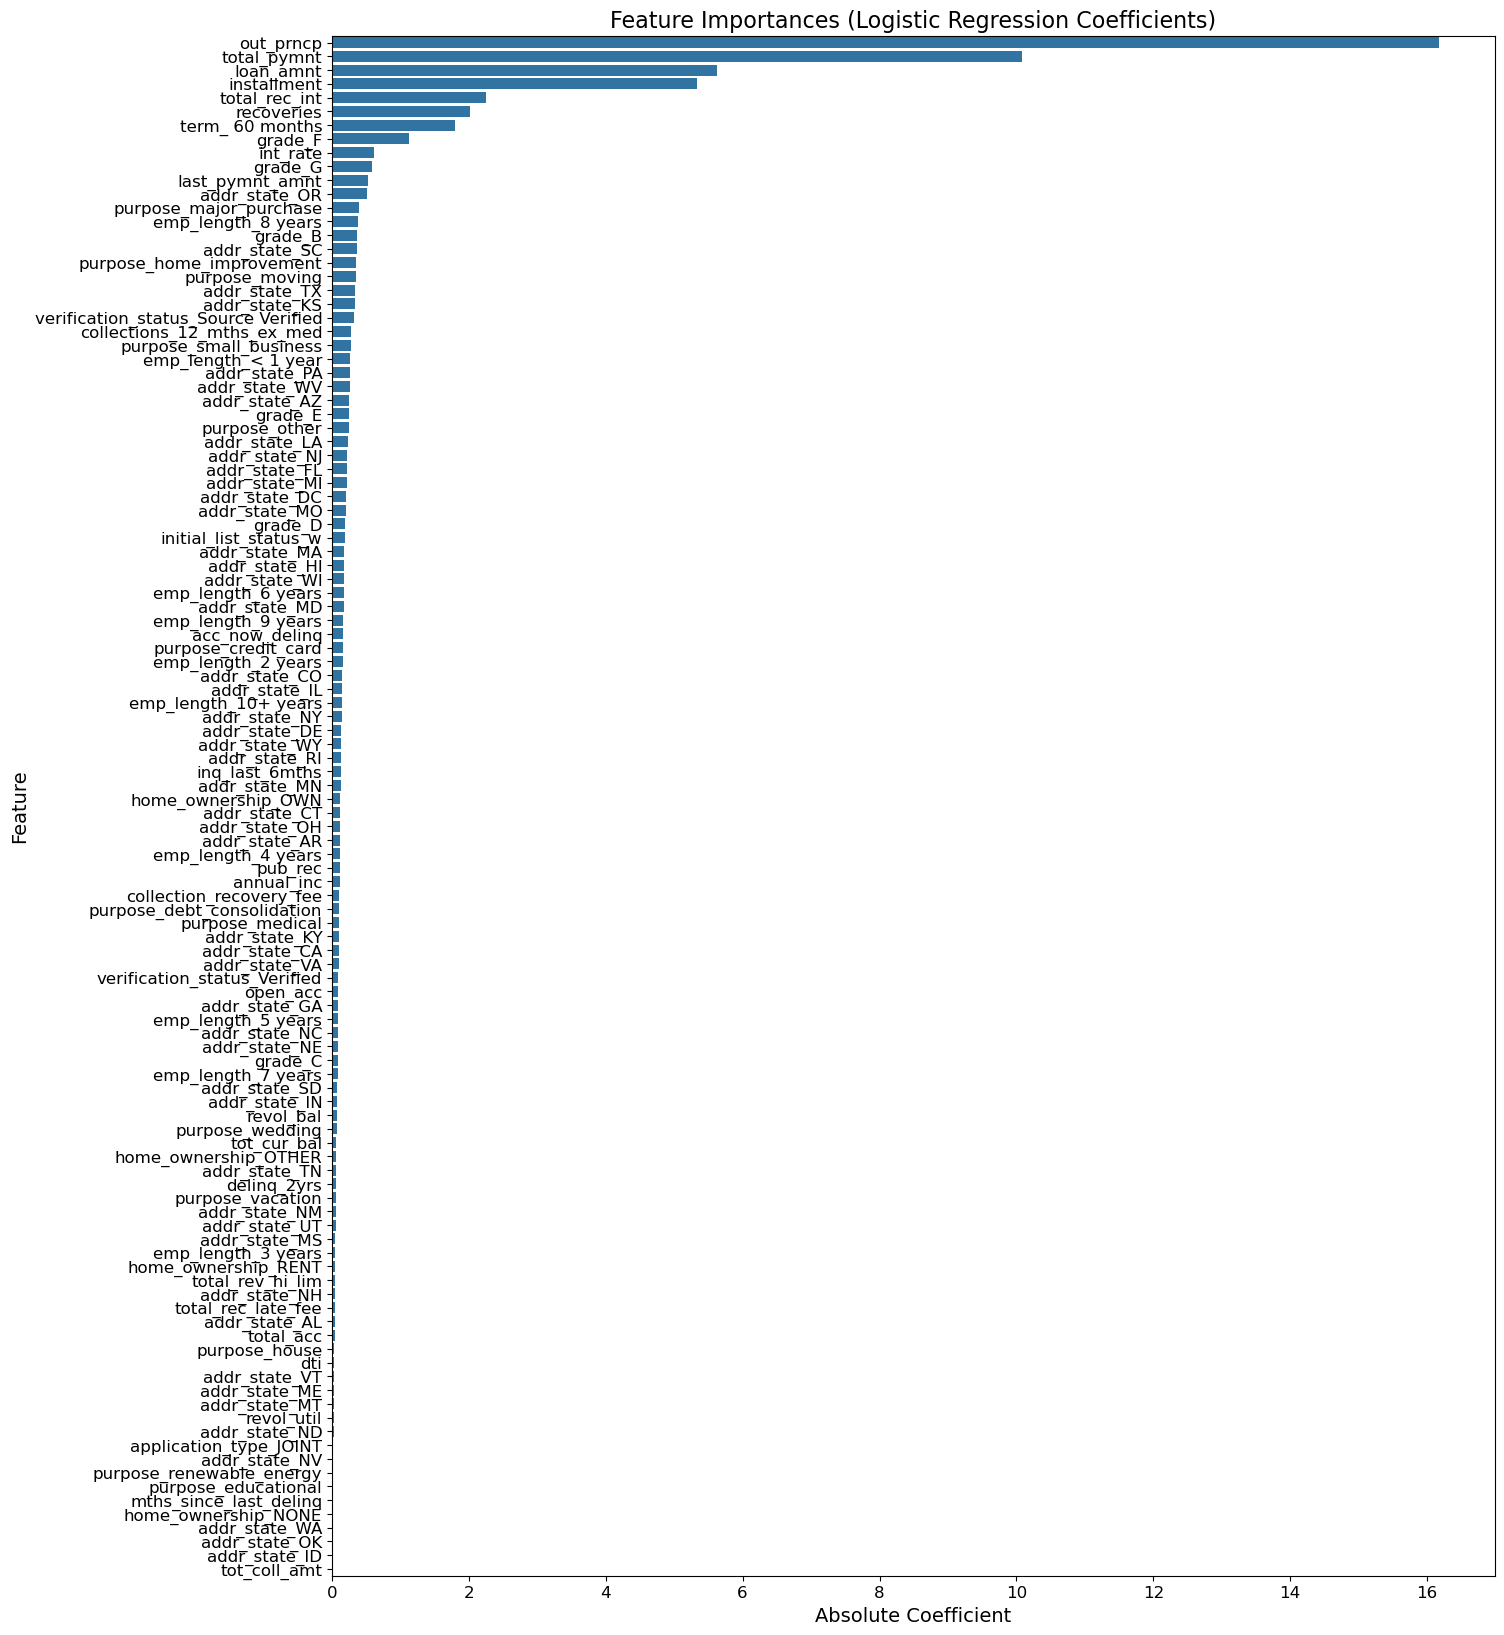


Training Set Evaluation Metrics:
Confusion Matrix:
[[48547    23]
 [  276  2512]]
Accuracy: 0.994
Precision: 0.991
Recall: 0.901
F1 Score: 0.944
Specificity: 1.000
ROC AUC: 0.989
Mean Squared Error (MSE): 0.006

Test Set Evaluation Metrics:
Confusion Matrix:
[[32367    13]
 [  149  1710]]
Accuracy: 0.995
Precision: 0.992
Recall: 0.920
F1 Score: 0.955
Specificity: 1.000
ROC AUC: 0.991
Mean Squared Error (MSE): 0.005


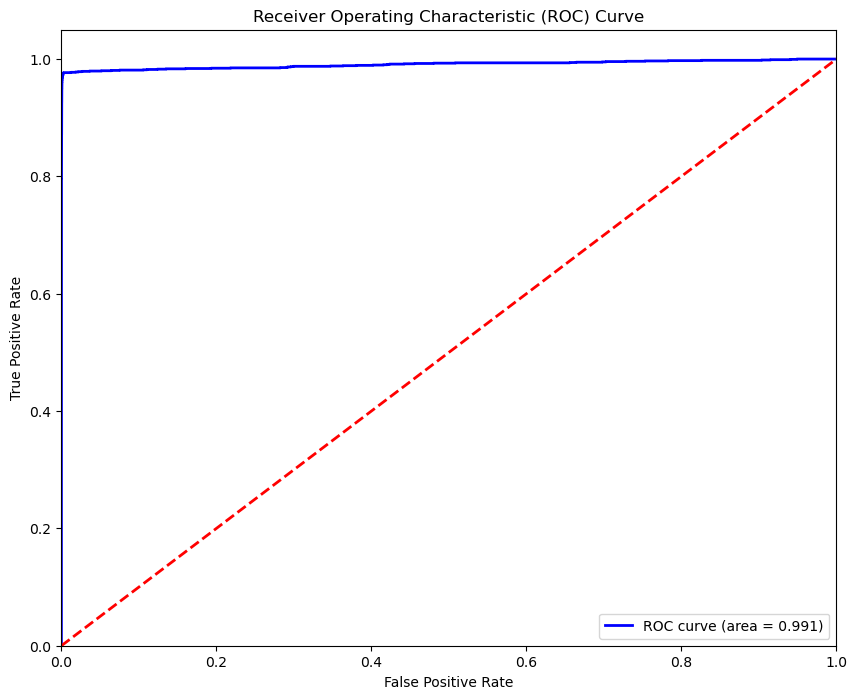


Comparison of Training and Testing Performance:
Training Accuracy: 0.994 vs Testing Accuracy: 0.995
Training Precision: 0.991 vs Testing Precision: 0.992
Training Recall: 0.901 vs Testing Recall: 0.920
Training F1 Score: 0.944 vs Testing F1 Score: 0.955
Training Specificity: 1.000 vs Testing Specificity: 1.000
Training ROC AUC: 0.989 vs Testing ROC AUC: 0.991
Training MSE: 0.006 vs Testing MSE: 0.005


In [11]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Separate numerical and categorical columns
numerical_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
                  'delinq_2yrs', 'inq_last_6mths','mths_since_last_delinq', 'open_acc', 
                  'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 
                  'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
                  'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

categorical_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 
                    'purpose', 'addr_state', 'initial_list_status', 'application_type']

# Define preprocessor for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Define preprocessor for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply transformations to the training set
X_train = preprocessor.fit_transform(X_train)

# Apply transformations to the test set
X_test = preprocessor.transform(X_test)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Get coefficients
coefficients = clf.coef_[0]

# Get feature names after one-hot encoding
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude
importances_df['Absolute Coefficient'] = importances_df['Coefficient'].abs()
importances_df = importances_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 20))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importances_df)
plt.title('Feature Importances (Logistic Regression Coefficients)',fontsize=16)
plt.xlabel('Absolute Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train[:, [feature_names.index(f) for f in top_features]]
X_test_top = X_test[:, [feature_names.index(f) for f in top_features]]

# Train a Logistic Regression model on top features
clf_logistic = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic.fit(X_train_top, y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_logistic.predict_proba(X_train_top)[:, 1]
y_train_pred = clf_logistic.predict(X_train_top)

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_logistic.predict_proba(X_test_top)[:, 1]
y_pred = clf_logistic.predict(X_test_top)

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')

# Logistic Regression Model Using Top Features With Frequency Encoder

C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tarek Moukalled\AppData\Local\Temp\ipykernel_9836\4076976031.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Absolute Coefficient', y='Feature', data=importances_df, ci=None)


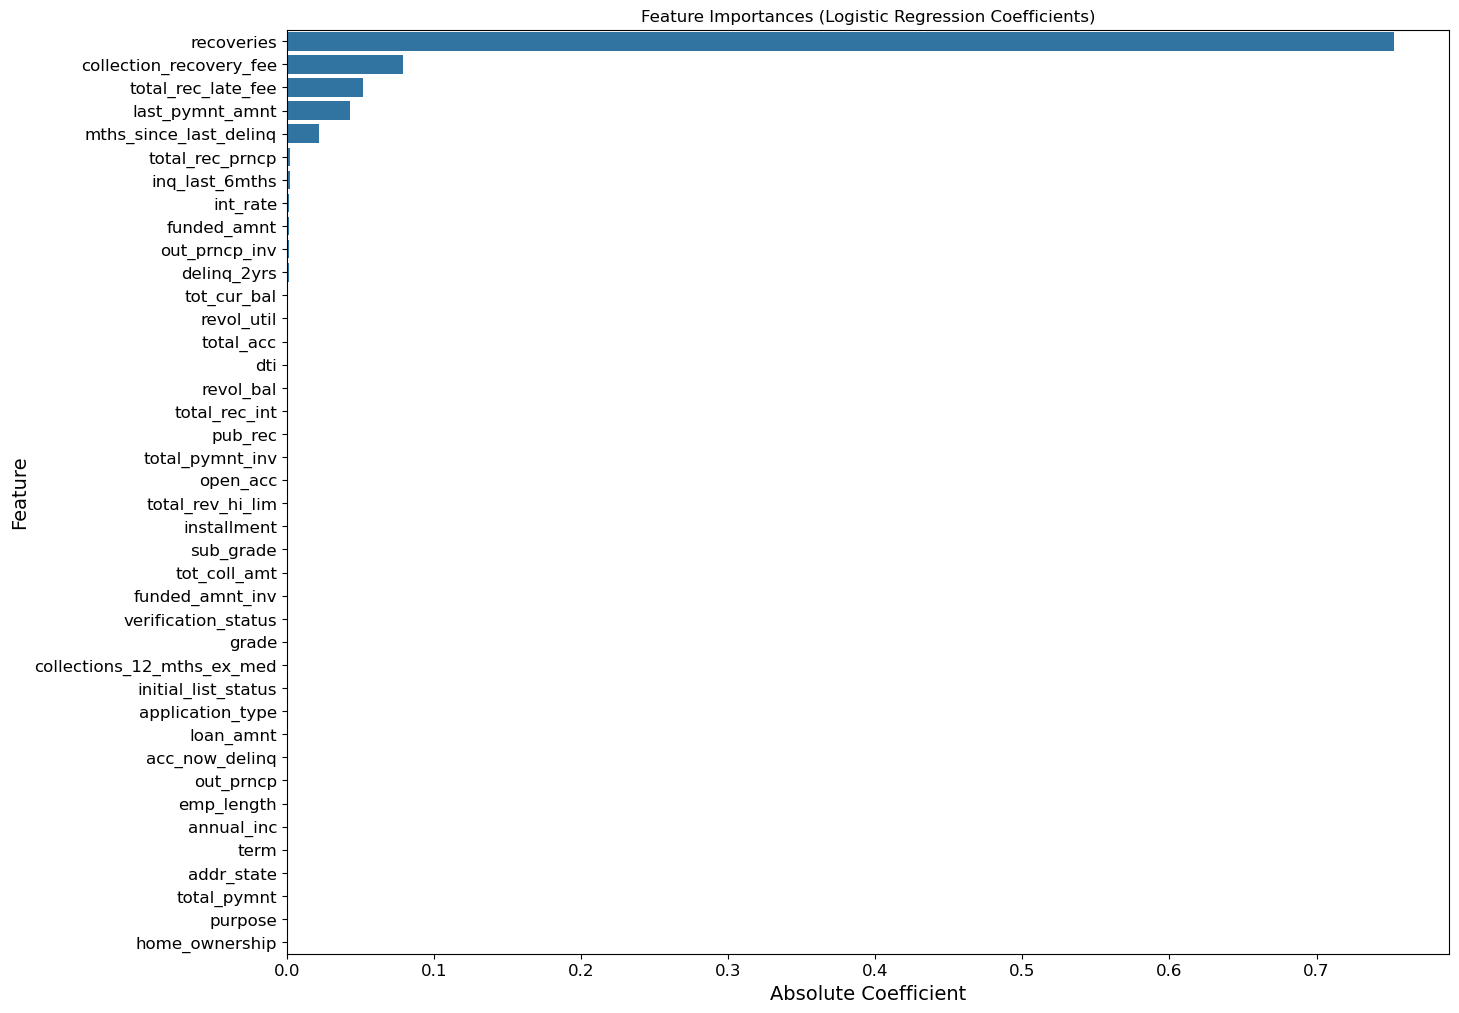


Training Set Evaluation Metrics:
Confusion Matrix:
[[48560    10]
 [ 1323  1465]]
Accuracy: 0.974
Precision: 0.993
Recall: 0.525
F1 Score: 0.687
Specificity: 1.000
ROC AUC: 0.887
Mean Squared Error (MSE): 0.026

Test Set Evaluation Metrics:
Confusion Matrix:
[[32379     1]
 [  889   970]]
Accuracy: 0.974
Precision: 0.999
Recall: 0.522
F1 Score: 0.686
Specificity: 1.000
ROC AUC: 0.886
Mean Squared Error (MSE): 0.026


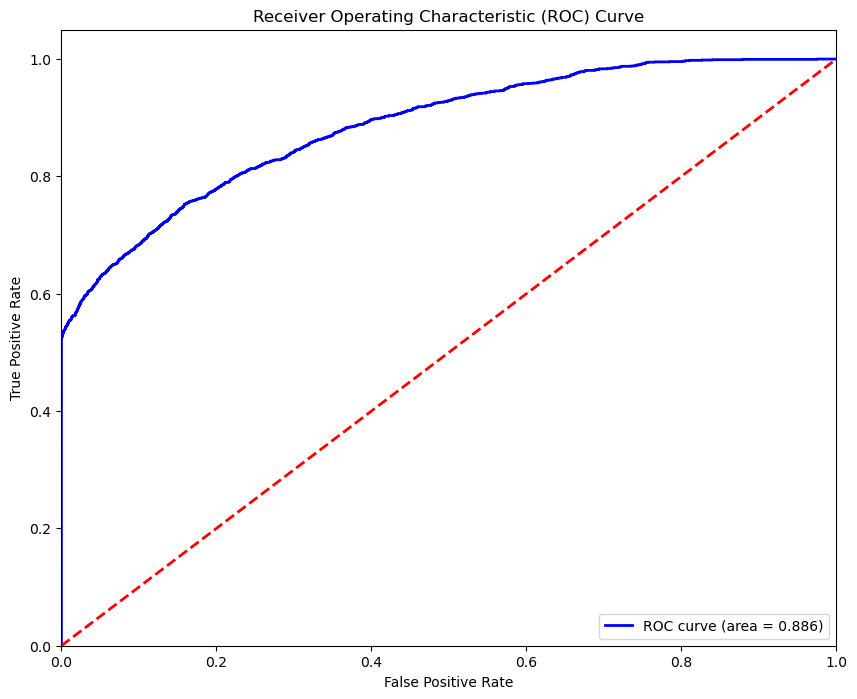


Comparison of Training and Testing Performance:
Training Accuracy: 0.974 vs Testing Accuracy: 0.974
Training Precision: 0.993 vs Testing Precision: 0.999
Training Recall: 0.525 vs Testing Recall: 0.522
Training F1 Score: 0.687 vs Testing F1 Score: 0.686
Training Specificity: 1.000 vs Testing Specificity: 1.000
Training ROC AUC: 0.887 vs Testing ROC AUC: 0.886
Training MSE: 0.026 vs Testing MSE: 0.026


In [12]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Separate numerical and categorical columns
numerical_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
                  'delinq_2yrs', 'inq_last_6mths','mths_since_last_delinq', 'open_acc', 
                  'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 
                  'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
                  'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

categorical_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
                    'purpose', 'addr_state', 'initial_list_status', 'application_type']

# Define preprocessor for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Apply transformations to the numerical columns
X_train[numerical_cols] = numerical_transformer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = numerical_transformer.transform(X_test[numerical_cols])

# Apply Frequency Encoder to the categorical columns
frequency_encoder = ce.CountEncoder(cols=categorical_cols)
X_train_encoded = frequency_encoder.fit_transform(X_train)
X_test_encoded = frequency_encoder.transform(X_test)

# Ensure all columns are numeric
X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce')
X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce')

# Impute any remaining missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

# Convert back to DataFrame to retain column names
X_train = pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test_encoded.columns)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Get coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for visualization
features = X_train.columns
importances_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude
importances_df['Absolute Coefficient'] = importances_df['Coefficient'].abs()
importances_df = importances_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importances_df, ci=None)
plt.title('Feature Importances (Logistic Regression Coefficients)')
plt.xlabel('Absolute Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train a Logistic Regression model on top features
clf_logistic = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic.fit(X_train_top, y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_logistic.predict_proba(X_train_top)[:, 1]
y_train_pred = clf_logistic.predict(X_train_top)

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_logistic.predict_proba(X_test_top)[:, 1]
y_pred = clf_logistic.predict(X_test_top)

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Logistic Regression Model Using Top Features With Target Encoder

C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


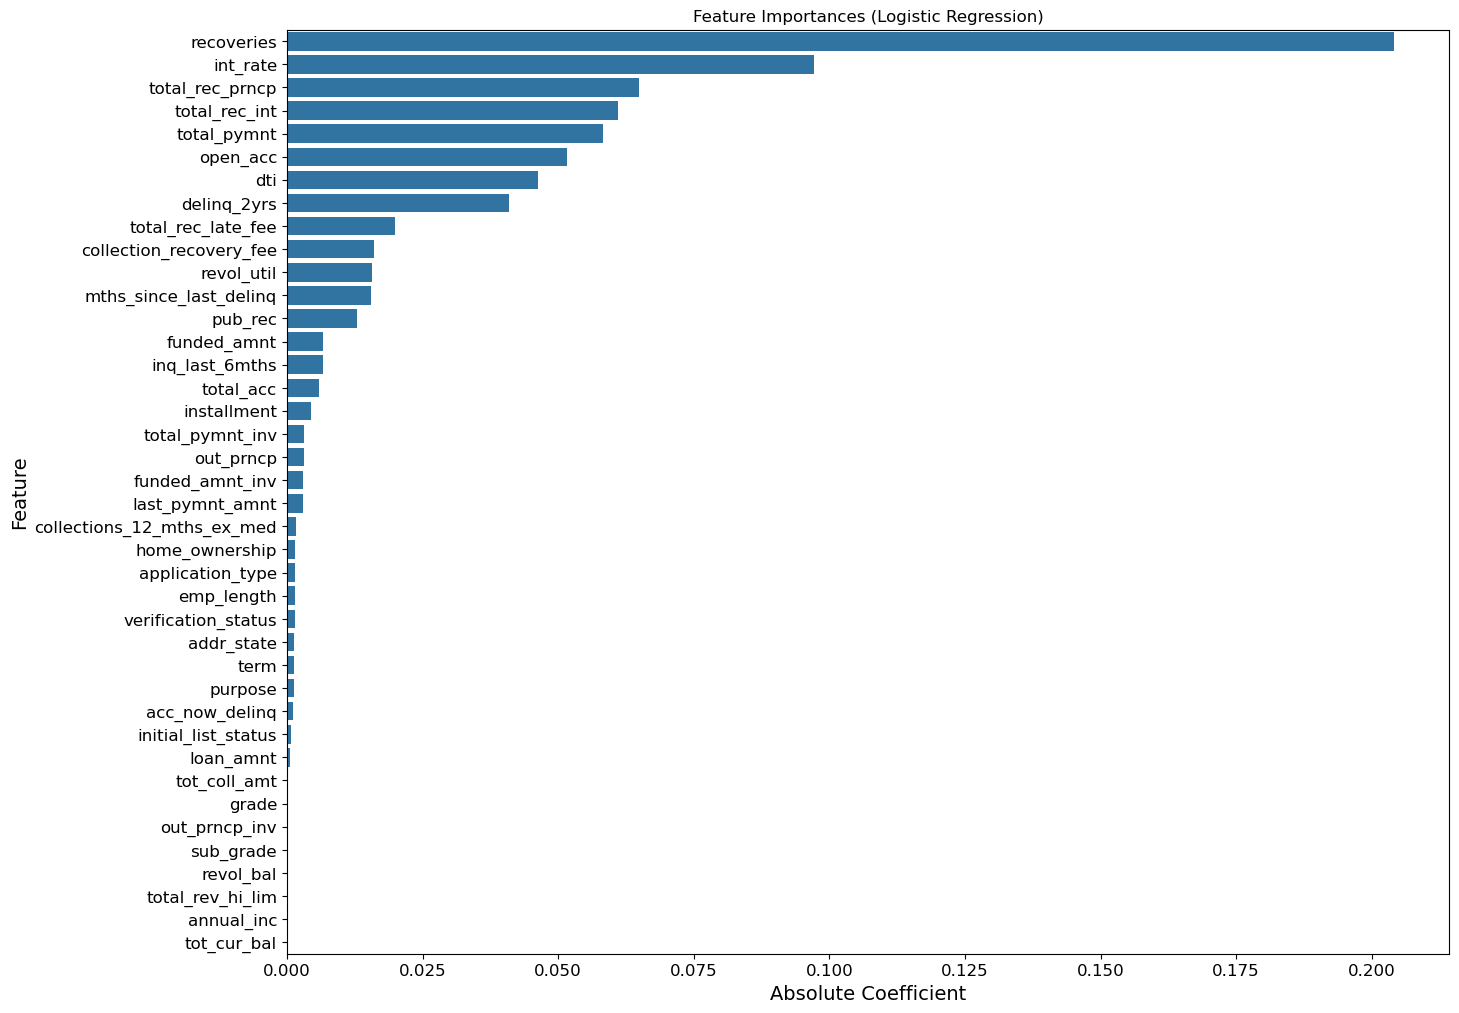


Training Set Evaluation Metrics:
Confusion Matrix:
[[48560    10]
 [ 1321  1467]]
Accuracy: 0.974
Precision: 0.993
Recall: 0.526
F1 Score: 0.688
Specificity: 1.000
ROC AUC: 0.877
Mean Squared Error (MSE): 0.026

Test Set Evaluation Metrics:
Confusion Matrix:
[[32378     2]
 [  888   971]]
Accuracy: 0.974
Precision: 0.998
Recall: 0.522
F1 Score: 0.686
Specificity: 1.000
ROC AUC: 0.878
Mean Squared Error (MSE): 0.026


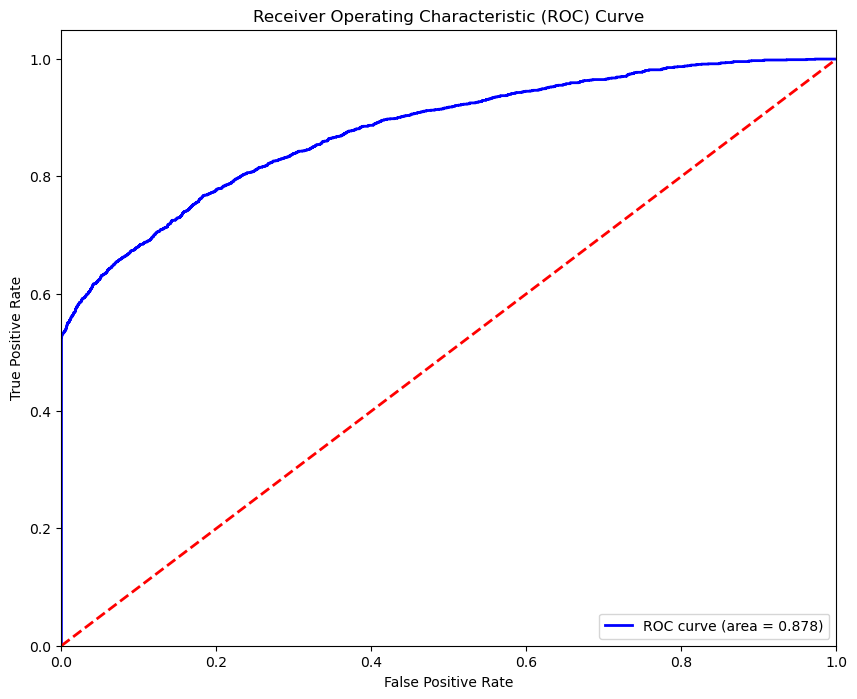


Comparison of Training and Testing Performance:
Training Accuracy: 0.974 vs Testing Accuracy: 0.974
Training Precision: 0.993 vs Testing Precision: 0.998
Training Recall: 0.526 vs Testing Recall: 0.522
Training F1 Score: 0.688 vs Testing F1 Score: 0.686
Training Specificity: 1.000 vs Testing Specificity: 1.000
Training ROC AUC: 0.877 vs Testing ROC AUC: 0.878
Training MSE: 0.026 vs Testing MSE: 0.026


In [13]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Apply Target encoding
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
encoder = ce.TargetEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Train the Logistic Regression model
clf_logistic = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic.fit(imputer.fit_transform(X_train_encoded), y_train)

# Get feature importances (coefficients)
feature_importances = clf_logistic.coef_[0]

# Create a DataFrame for visualization
features = X_train_encoded.columns
importances_df = pd.DataFrame({'Feature': features, 'Coefficient': feature_importances})

# Sort the DataFrame by importance
importances_df['Absolute Coefficient'] = importances_df['Coefficient'].abs()
importances_df = importances_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importances_df)
plt.title('Feature Importances (Logistic Regression)')
plt.xlabel('Absolute Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

# Train a Logistic Regression model on top features
clf_logistic_top = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic_top.fit(imputer.fit_transform(X_train_top), y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_logistic_top.predict_proba(imputer.transform(X_train_top))[:, 1]
y_train_pred = clf_logistic_top.predict(imputer.transform(X_train_top))

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_logistic_top.predict_proba(imputer.transform(X_test_top))[:, 1]
y_pred = clf_logistic_top.predict(imputer.transform(X_test_top))

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Logistic Regression Model Using Top Features With Weight of Evidence Encoder

C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


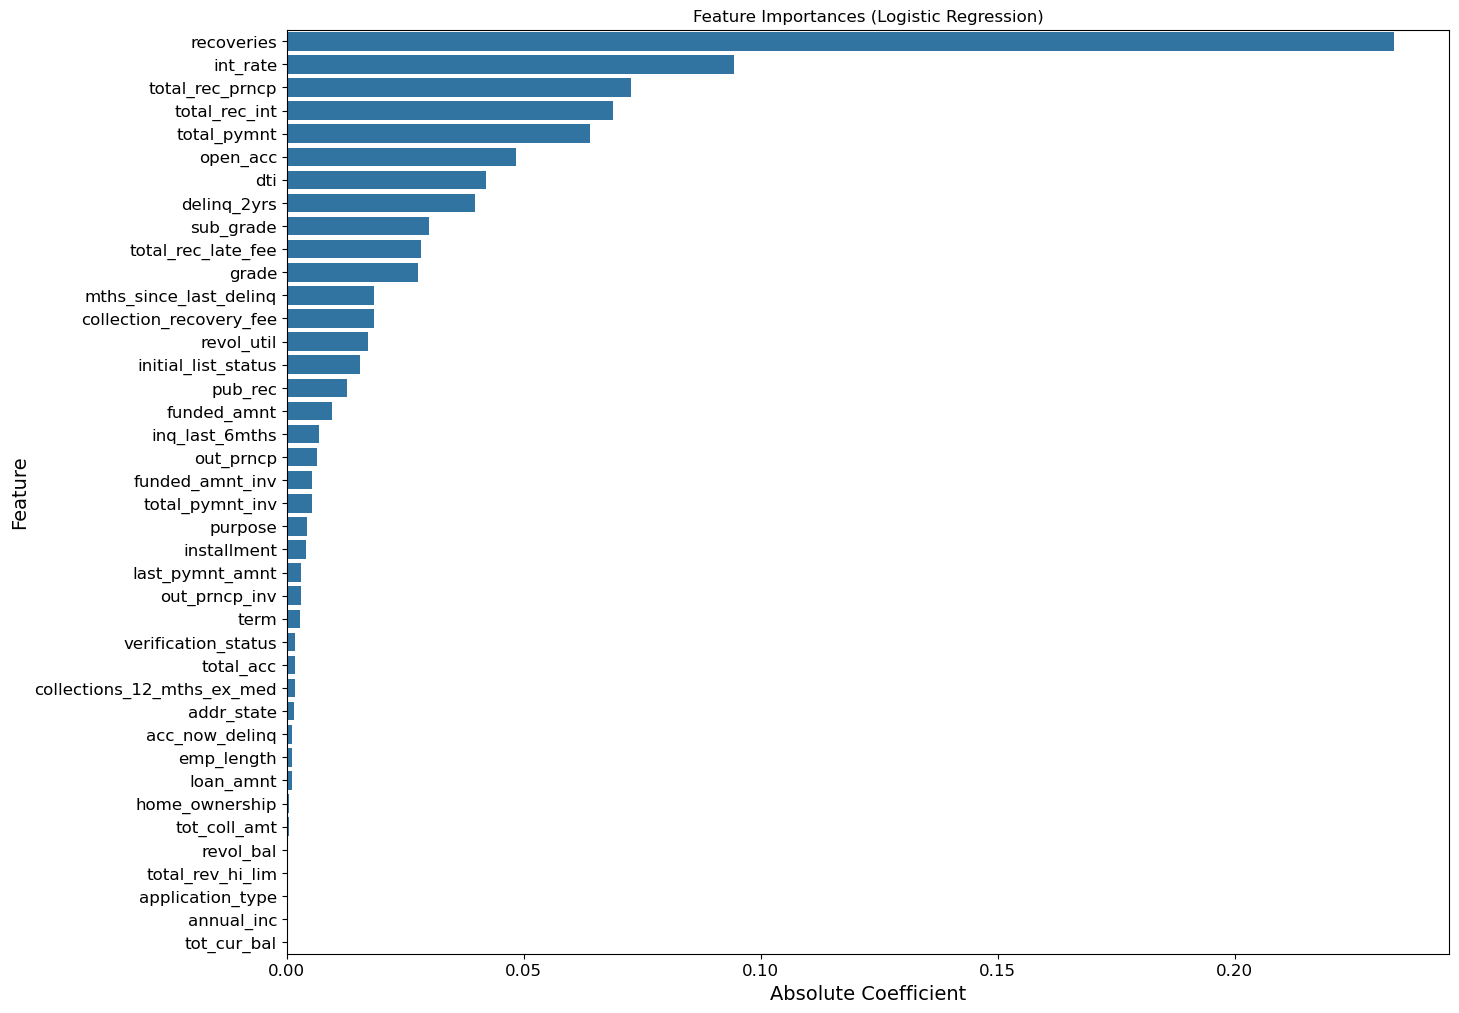


Training Set Evaluation Metrics:
Confusion Matrix:
[[48560    10]
 [ 1321  1467]]
Accuracy: 0.974
Precision: 0.993
Recall: 0.526
F1 Score: 0.688
Specificity: 1.000
ROC AUC: 0.877
Mean Squared Error (MSE): 0.026

Test Set Evaluation Metrics:
Confusion Matrix:
[[32378     2]
 [  888   971]]
Accuracy: 0.974
Precision: 0.998
Recall: 0.522
F1 Score: 0.686
Specificity: 1.000
ROC AUC: 0.878
Mean Squared Error (MSE): 0.026


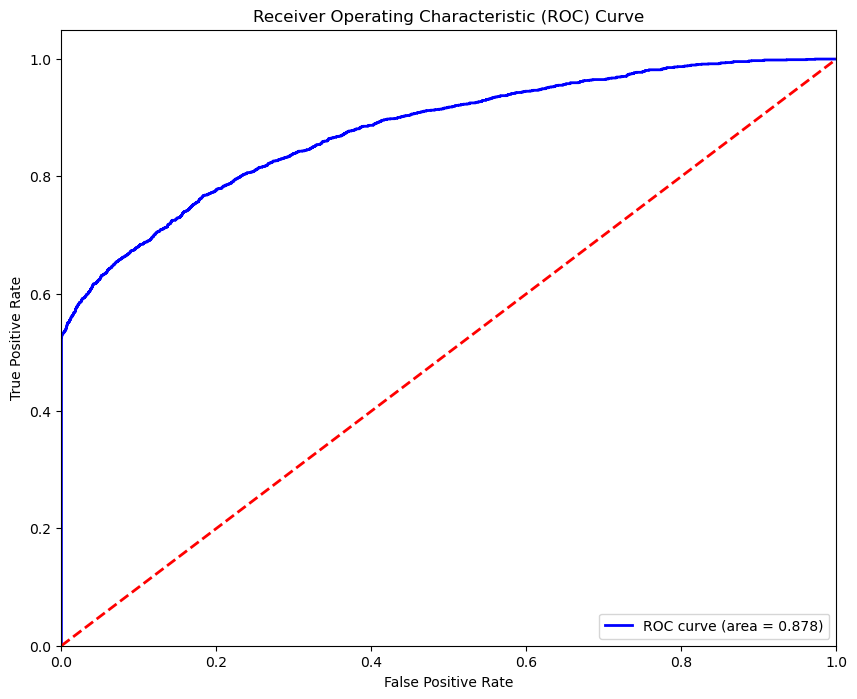


Comparison of Training and Testing Performance:
Training Accuracy: 0.974 vs Testing Accuracy: 0.974
Training Precision: 0.993 vs Testing Precision: 0.998
Training Recall: 0.526 vs Testing Recall: 0.522
Training F1 Score: 0.688 vs Testing F1 Score: 0.686
Training Specificity: 1.000 vs Testing Specificity: 1.000
Training ROC AUC: 0.877 vs Testing ROC AUC: 0.878
Training MSE: 0.026 vs Testing MSE: 0.026


In [14]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Apply WoE encoding
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
encoder = ce.WOEEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Train the Logistic Regression model
clf_logistic = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic.fit(imputer.fit_transform(X_train_encoded), y_train)

# Get feature importances (coefficients)
feature_importances = clf_logistic.coef_[0]

# Create a DataFrame for visualization
features = X_train_encoded.columns
importances_df = pd.DataFrame({'Feature': features, 'Coefficient': feature_importances})

# Sort the DataFrame by importance
importances_df['Absolute Coefficient'] = importances_df['Coefficient'].abs()
importances_df = importances_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importances_df)
plt.title('Feature Importances (Logistic Regression)')
plt.xlabel('Absolute Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

# Train a Logistic Regression model on top features
clf_logistic_top = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic_top.fit(imputer.fit_transform(X_train_top), y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_logistic_top.predict_proba(imputer.transform(X_train_top))[:, 1]
y_train_pred = clf_logistic_top.predict(imputer.transform(X_train_top))

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_logistic_top.predict_proba(imputer.transform(X_test_top))[:, 1]
y_pred = clf_logistic_top.predict(imputer.transform(X_test_top))

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Logistic Regression Model Using Top Features With Binary Encoder

C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


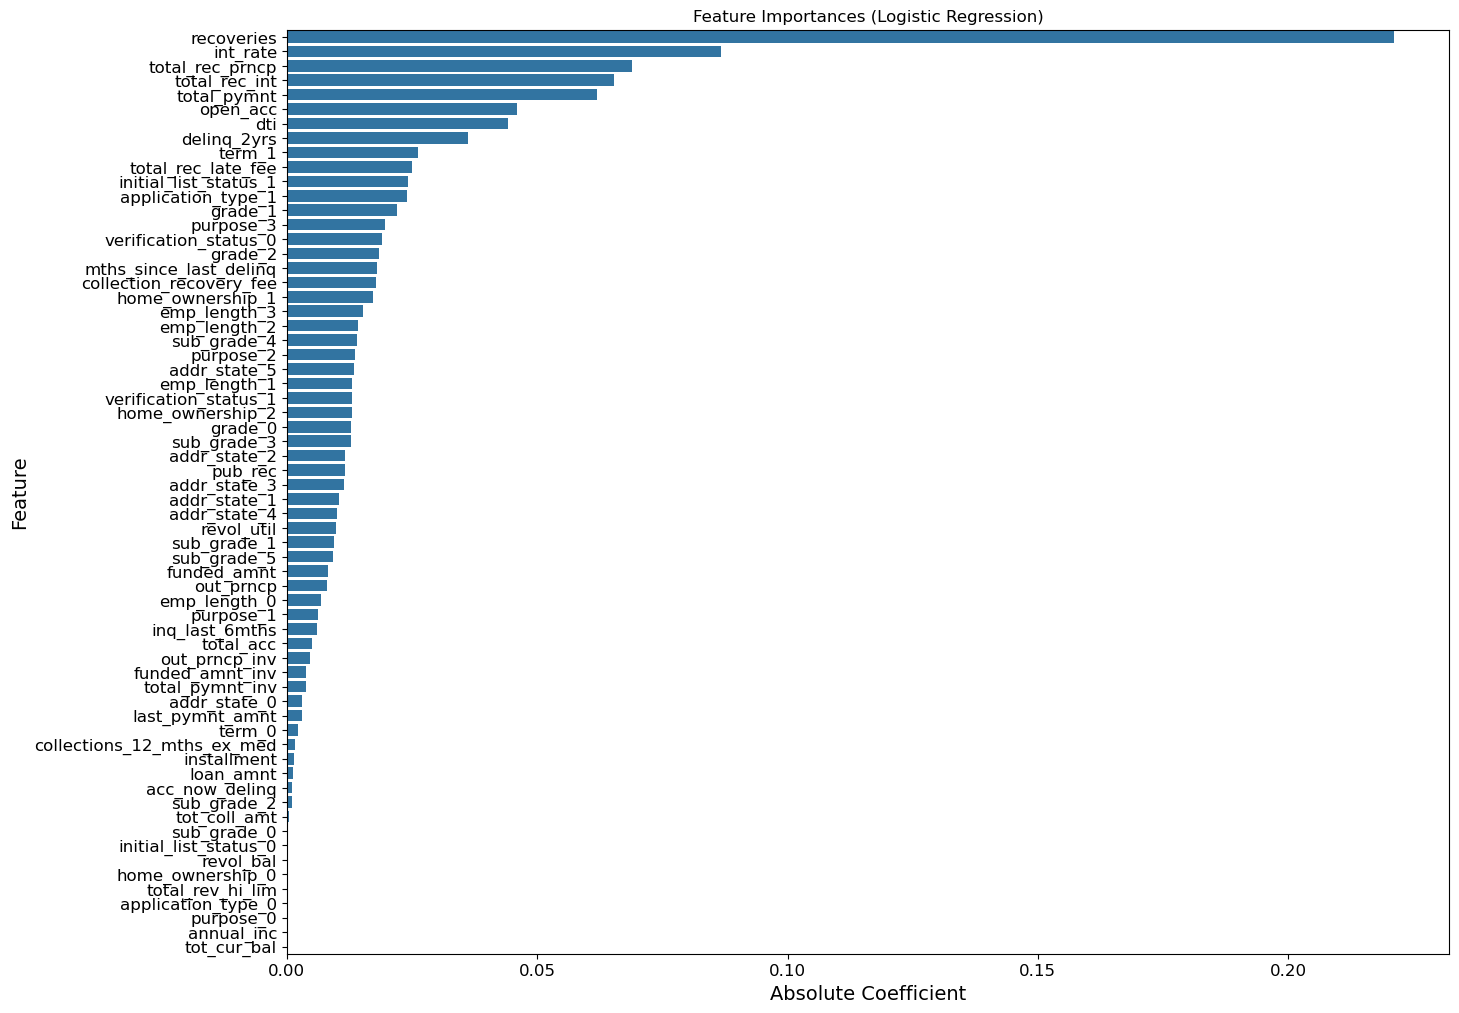


Training Set Evaluation Metrics:
Confusion Matrix:
[[48560    10]
 [ 1321  1467]]
Accuracy: 0.974
Precision: 0.993
Recall: 0.526
F1 Score: 0.688
Specificity: 1.000
ROC AUC: 0.877
Mean Squared Error (MSE): 0.026

Test Set Evaluation Metrics:
Confusion Matrix:
[[32378     2]
 [  888   971]]
Accuracy: 0.974
Precision: 0.998
Recall: 0.522
F1 Score: 0.686
Specificity: 1.000
ROC AUC: 0.878
Mean Squared Error (MSE): 0.026


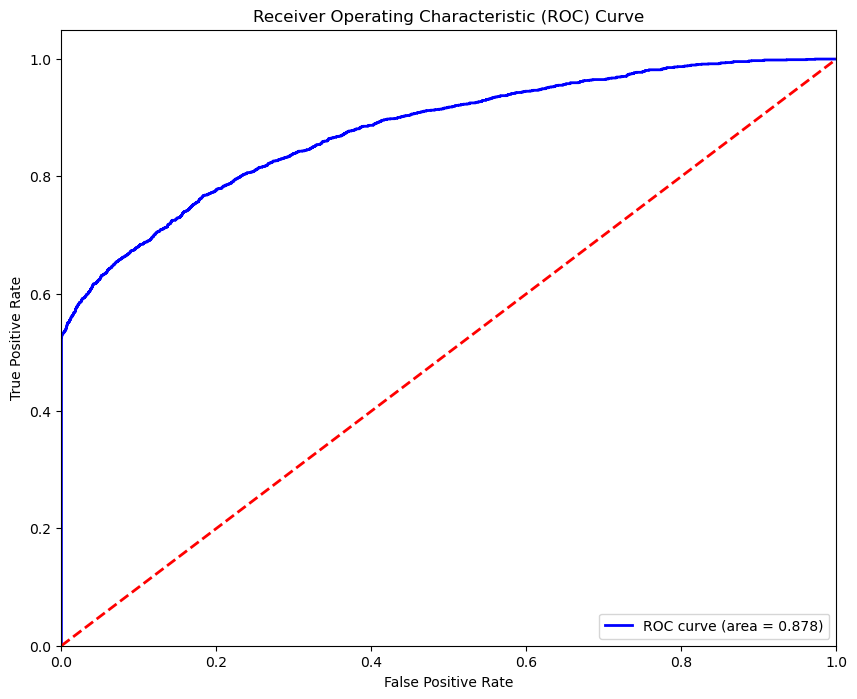


Comparison of Training and Testing Performance:
Training Accuracy: 0.974 vs Testing Accuracy: 0.974
Training Precision: 0.993 vs Testing Precision: 0.998
Training Recall: 0.526 vs Testing Recall: 0.522
Training F1 Score: 0.688 vs Testing F1 Score: 0.686
Training Specificity: 1.000 vs Testing Specificity: 1.000
Training ROC AUC: 0.877 vs Testing ROC AUC: 0.878
Training MSE: 0.026 vs Testing MSE: 0.026


In [15]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Apply Binary encoding
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
encoder = ce.BinaryEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Train the Logistic Regression model
clf_logistic = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic.fit(imputer.fit_transform(X_train_encoded), y_train)

# Get coefficients as feature importances
feature_importances = clf_logistic.coef_[0]

# Create a DataFrame for visualization
features = X_train_encoded.columns
importances_df = pd.DataFrame({'Feature': features, 'Coefficient': feature_importances})

# Sort the DataFrame by absolute importance
importances_df['Absolute Coefficient'] = importances_df['Coefficient'].abs()
importances_df = importances_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importances_df)
plt.title('Feature Importances (Logistic Regression)')
plt.xlabel('Absolute Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

# Train a Logistic Regression model on top features
clf_logistic_top = LogisticRegression(random_state=42, max_iter=10000)
clf_logistic_top.fit(imputer.fit_transform(X_train_top), y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_logistic_top.predict_proba(imputer.transform(X_train_top))[:, 1]
y_train_pred = clf_logistic_top.predict(imputer.transform(X_train_top))

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_logistic_top.predict_proba(imputer.transform(X_test_top))[:, 1]
y_pred = clf_logistic_top.predict(imputer.transform(X_test_top))

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Random Forest Model Using Top Features With LabelEncoder

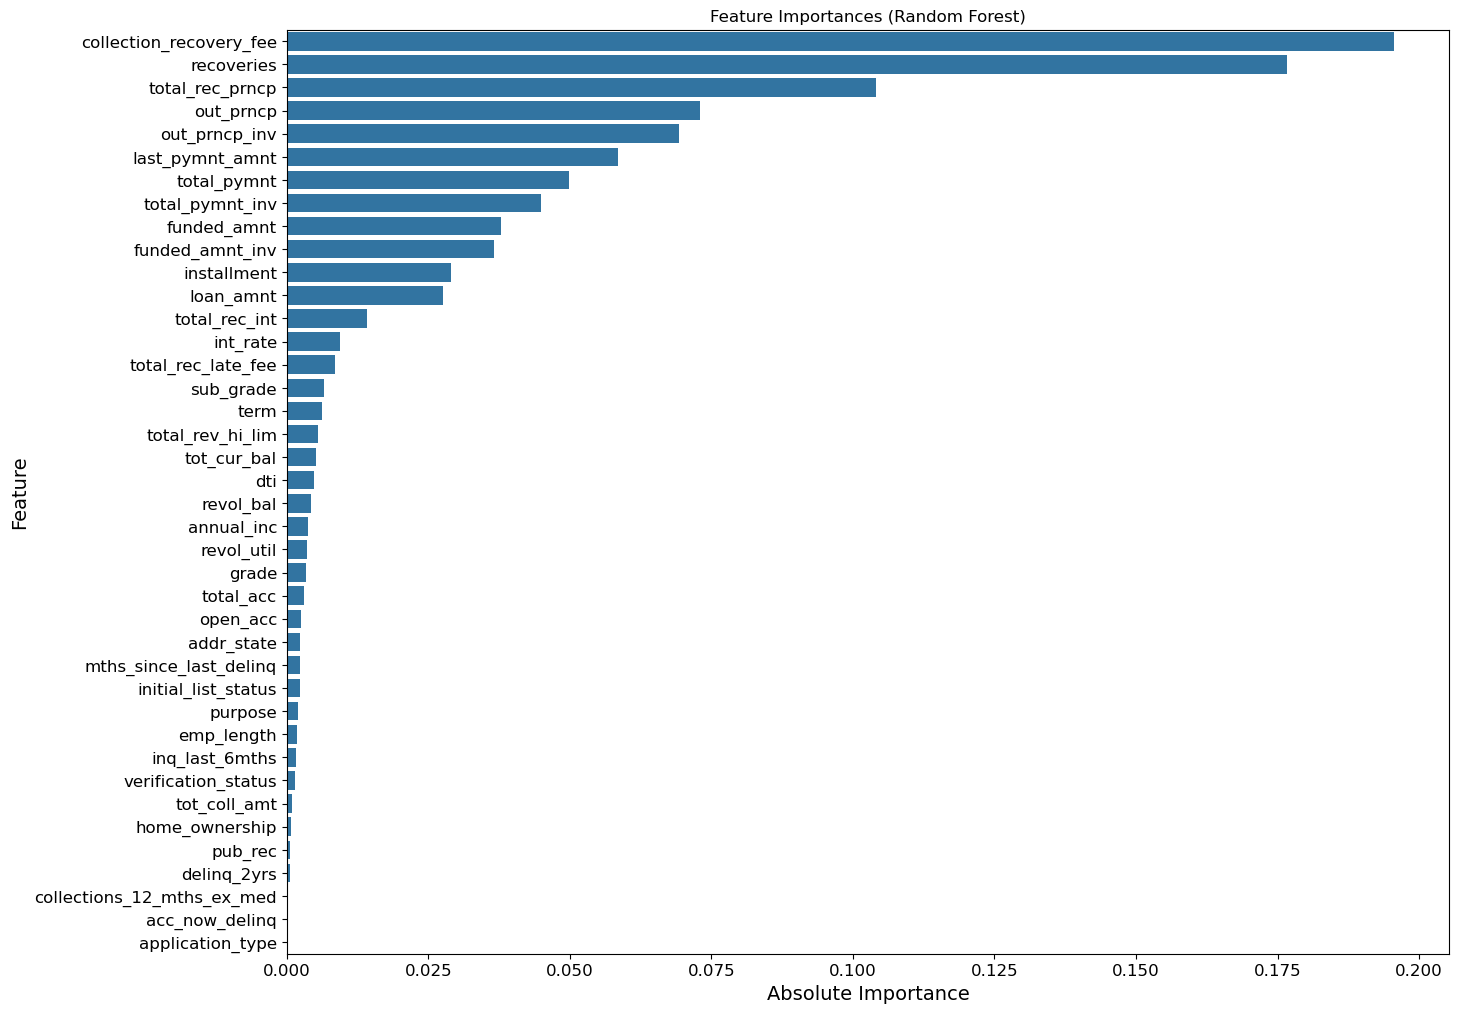


Training Set Evaluation Metrics:
Confusion Matrix:
[[48570     0]
 [    2  2786]]
Accuracy: 1.000
Precision: 1.000
Recall: 0.999
F1 Score: 1.000
Specificity: 1.000
ROC AUC: 1.000
Mean Squared Error (MSE): 0.000

Test Set Evaluation Metrics:
Confusion Matrix:
[[32352    28]
 [  129  1730]]
Accuracy: 0.995
Precision: 0.984
Recall: 0.931
F1 Score: 0.957
Specificity: 0.999
ROC AUC: 0.987
Mean Squared Error (MSE): 0.005


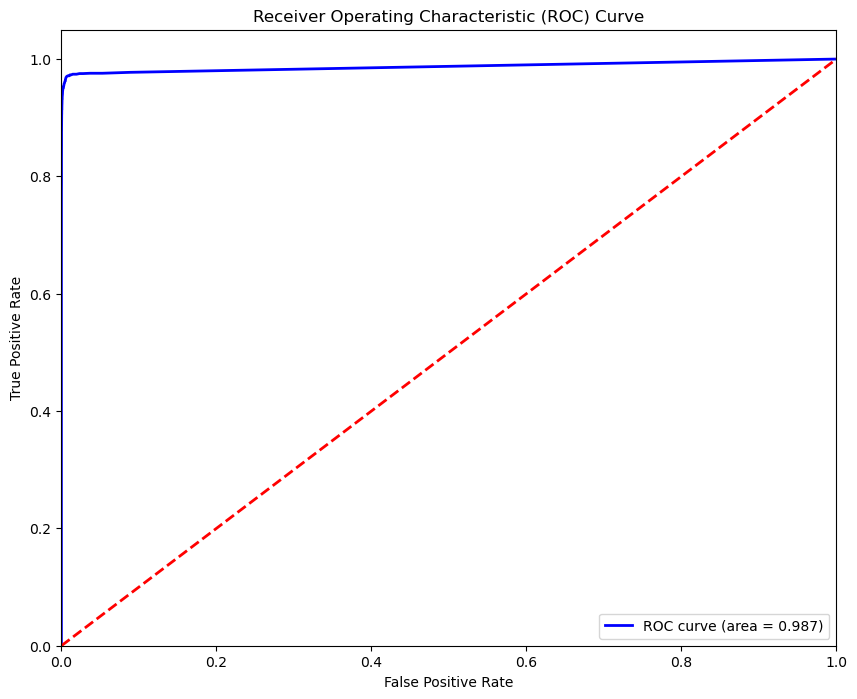


Comparison of Training and Testing Performance:
Training Accuracy: 1.000 vs Testing Accuracy: 0.995
Training Precision: 1.000 vs Testing Precision: 0.984
Training Recall: 0.999 vs Testing Recall: 0.931
Training F1 Score: 1.000 vs Testing F1 Score: 0.957
Training Specificity: 1.000 vs Testing Specificity: 0.999
Training ROC AUC: 1.000 vs Testing ROC AUC: 0.987
Training MSE: 0.000 vs Testing MSE: 0.005


In [16]:
# Encode categorical variables
df5_encoded = df5.copy()
label_encoders = {}

for column in df5_encoded.select_dtypes(include=['category']).columns:
    label_encoders[column] = LabelEncoder()
    df5_encoded[column] = label_encoders[column].fit_transform(df5_encoded[column])

# Define features and target
X = df5_encoded.drop(columns=['default_ind'])
y = df5_encoded['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Handle missing values
numerical_imputer = SimpleImputer(strategy='median')

# Separate numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Impute missing values in numerical columns
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])

# Scale numerical features
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame for visualization
features = X_train.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df['Absolute Importance'] = importances_df['Importance'].abs()
importances_df = importances_df.sort_values(by='Absolute Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Importance', y='Feature', data=importances_df)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Absolute Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train a Random Forest model on top features
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_top, y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_rf.predict_proba(X_train_top)[:, 1]
y_train_pred = clf_rf.predict(X_train_top)

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_rf.predict_proba(X_test_top)[:, 1]
y_pred = clf_rf.predict(X_test_top)

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Random Forest Model Using Top Features With OneHotEncoder

C:\Users\Tarek Moukalled\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


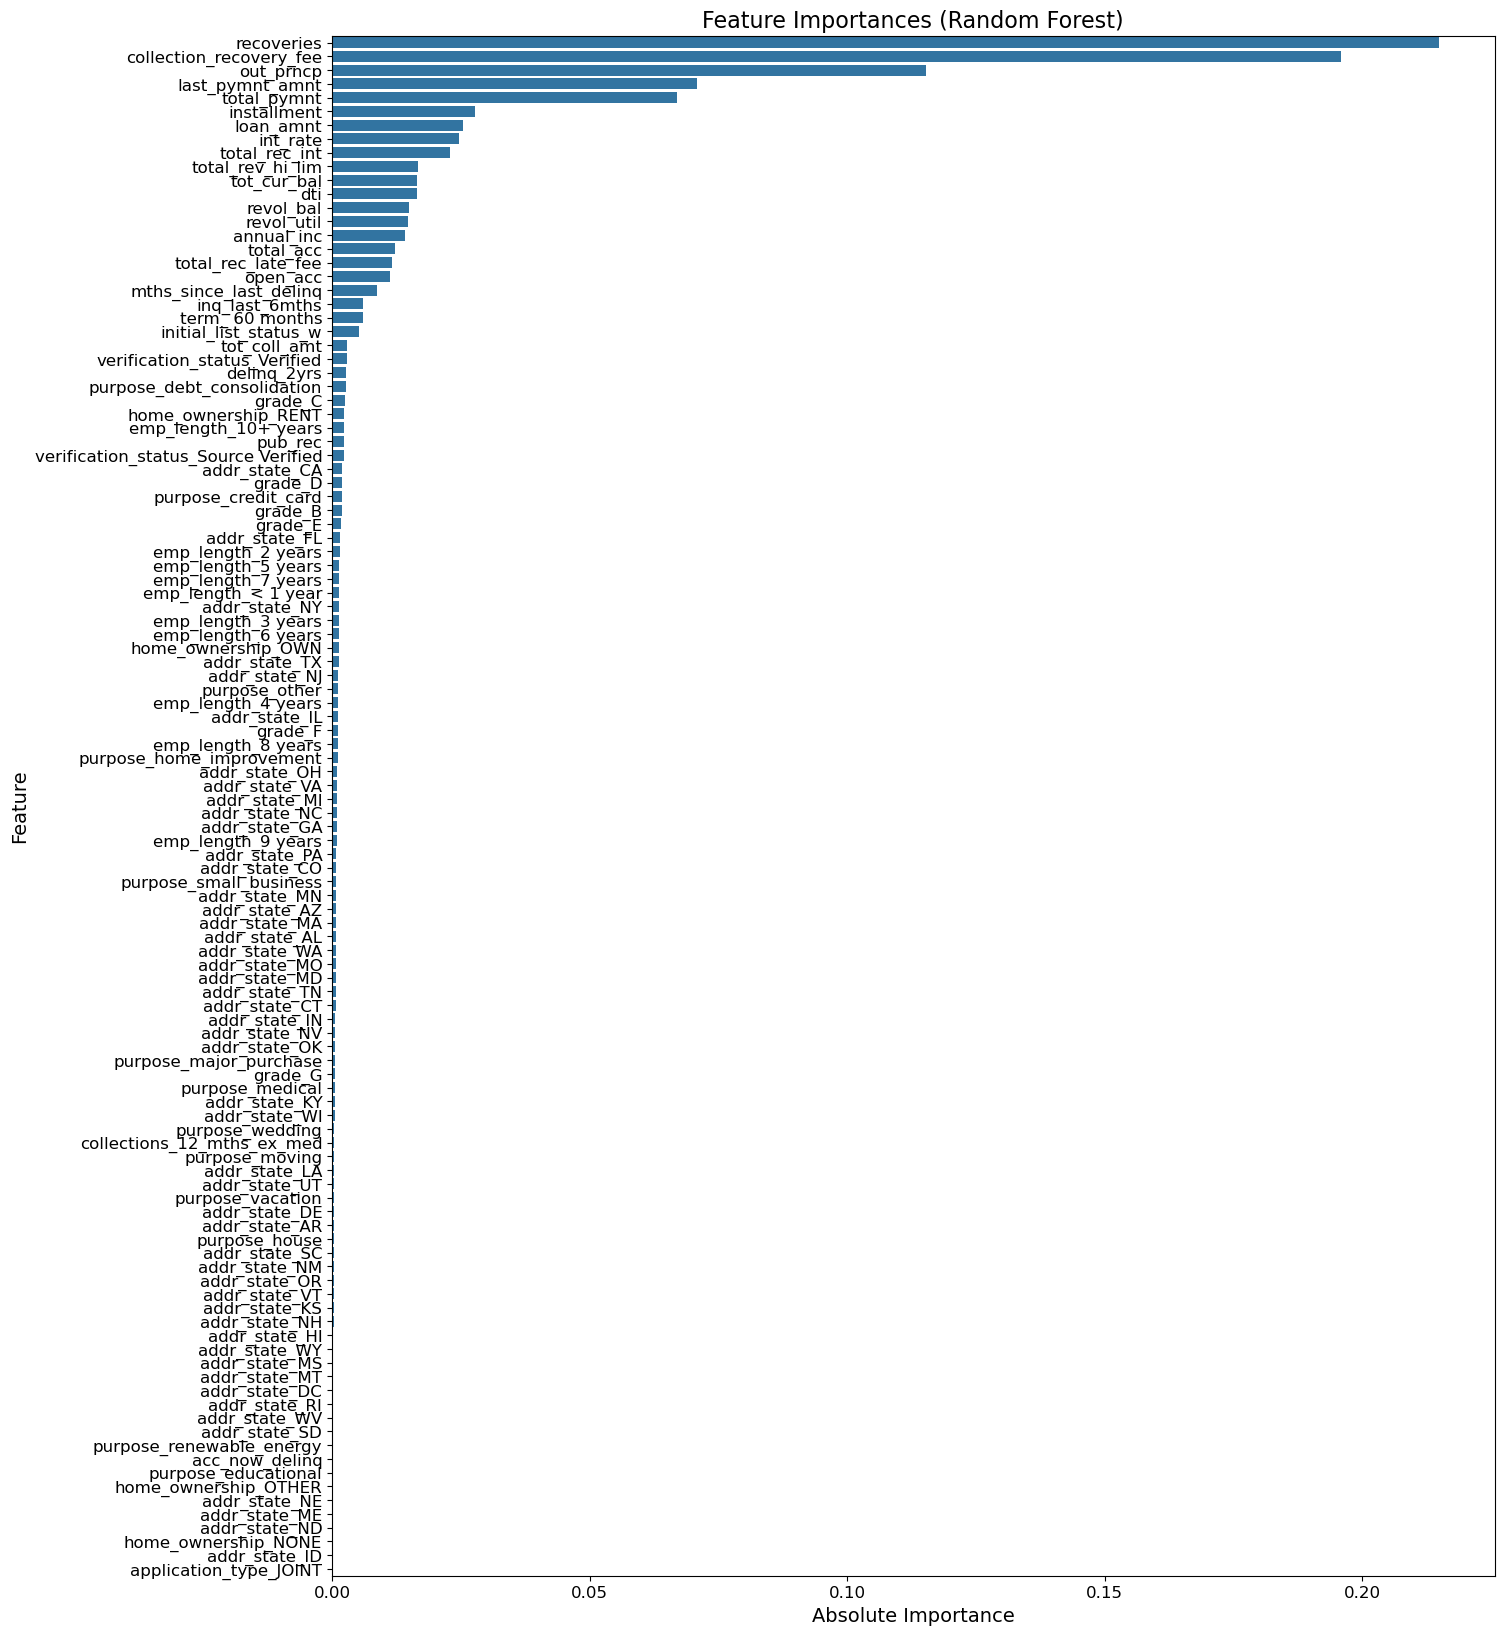


Training Set Evaluation Metrics:
Confusion Matrix:
[[48570     0]
 [    2  2786]]
Accuracy: 1.000
Precision: 1.000
Recall: 0.999
F1 Score: 1.000
Specificity: 1.000
ROC AUC: 1.000
Mean Squared Error (MSE): 0.000

Test Set Evaluation Metrics:
Confusion Matrix:
[[32377     3]
 [   93  1766]]
Accuracy: 0.997
Precision: 0.998
Recall: 0.950
F1 Score: 0.974
Specificity: 1.000
ROC AUC: 0.990
Mean Squared Error (MSE): 0.003


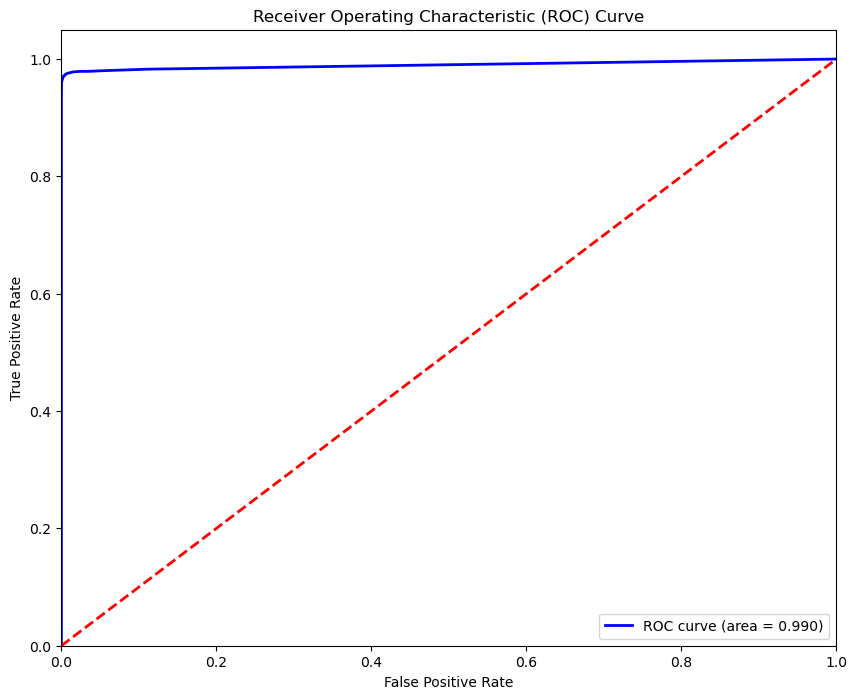


Comparison of Training and Testing Performance:
Training Accuracy: 1.000 vs Testing Accuracy: 0.997
Training Precision: 1.000 vs Testing Precision: 0.998
Training Recall: 0.999 vs Testing Recall: 0.950
Training F1 Score: 1.000 vs Testing F1 Score: 0.974
Training Specificity: 1.000 vs Testing Specificity: 1.000
Training ROC AUC: 1.000 vs Testing ROC AUC: 0.990
Training MSE: 0.000 vs Testing MSE: 0.003


In [17]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Separate numerical and categorical columns
numerical_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
                  'delinq_2yrs', 'inq_last_6mths','mths_since_last_delinq', 'open_acc', 
                  'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 
                  'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
                  'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

categorical_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 
                    'purpose', 'addr_state', 'initial_list_status', 'application_type']

# Define preprocessor for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Define preprocessor for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply transformations to the training set
X_train = preprocessor.fit_transform(X_train)

# Apply transformations to the test set
X_test = preprocessor.transform(X_test)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Get feature names after one-hot encoding
numerical_features = numerical_cols
categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
feature_names = numerical_features + list(categorical_features)

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df['Absolute Importance'] = importances_df['Importance'].abs()
importances_df = importances_df.sort_values(by='Absolute Importance', ascending=False)

# Plot the feature importances with improved readability
plt.figure(figsize=(15, 20))
sns.barplot(x='Absolute Importance', y='Feature', data=importances_df)
plt.title('Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Absolute Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train[:, [feature_names.index(f) for f in top_features]]
X_test_top = X_test[:, [feature_names.index(f) for f in top_features]]

# Train a Random Forest model on top features
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_top, y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_rf.predict_proba(X_train_top)[:, 1]
y_train_pred = clf_rf.predict(X_train_top)

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_rf.predict_proba(X_test_top)[:, 1]
y_pred = clf_rf.predict(X_test_top)

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Random Forest Model Using Top Features with Frequency Encoding

C:\Users\Tarek Moukalled\AppData\Local\Temp\ipykernel_9836\830796702.py:63: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df, ci=None)


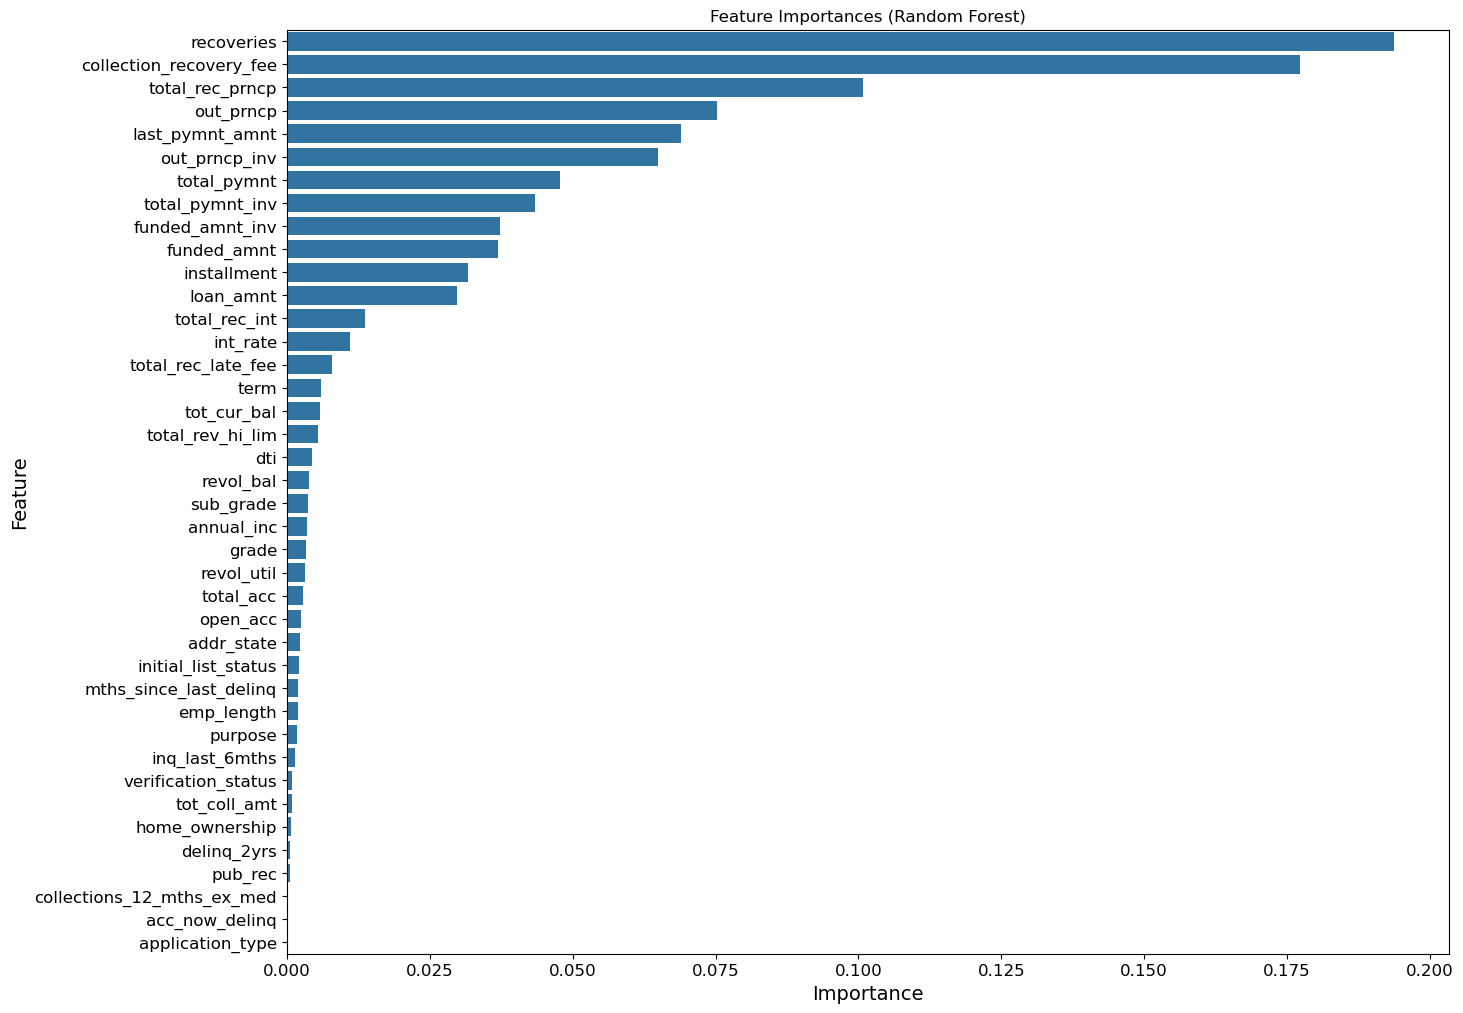


Training Set Evaluation Metrics:
Confusion Matrix:
[[48570     0]
 [    2  2786]]
Accuracy: 1.000
Precision: 1.000
Recall: 0.999
F1 Score: 1.000
Specificity: 1.000
ROC AUC: 1.000
Mean Squared Error (MSE): 0.000

Test Set Evaluation Metrics:
Confusion Matrix:
[[32355    25]
 [  129  1730]]
Accuracy: 0.996
Precision: 0.986
Recall: 0.931
F1 Score: 0.957
Specificity: 0.999
ROC AUC: 0.989
Mean Squared Error (MSE): 0.004


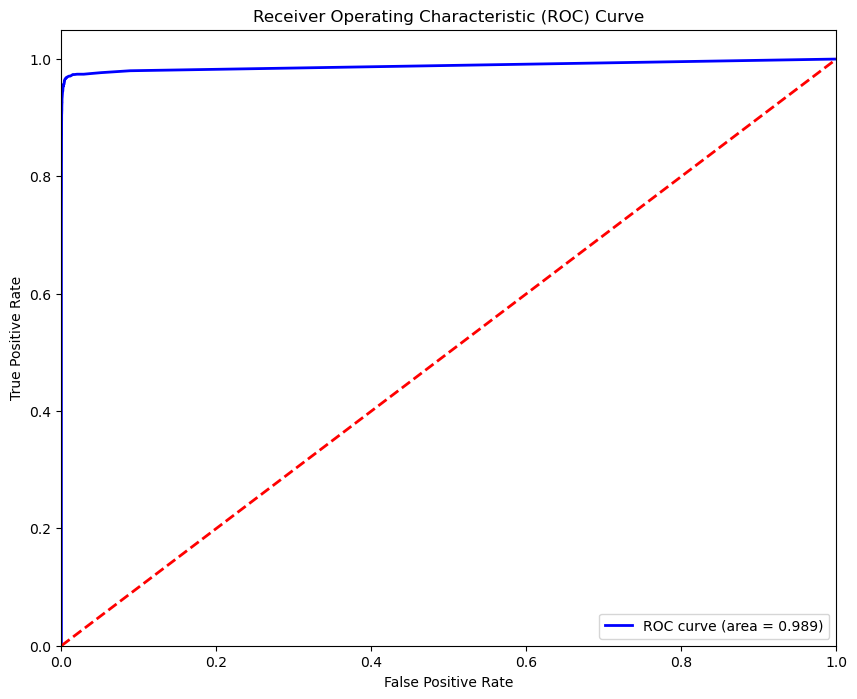


Comparison of Training and Testing Performance:
Training Accuracy: 1.000 vs Testing Accuracy: 0.996
Training Precision: 1.000 vs Testing Precision: 0.986
Training Recall: 0.999 vs Testing Recall: 0.931
Training F1 Score: 1.000 vs Testing F1 Score: 0.957
Training Specificity: 1.000 vs Testing Specificity: 0.999
Training ROC AUC: 1.000 vs Testing ROC AUC: 0.989
Training MSE: 0.000 vs Testing MSE: 0.004


In [18]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Separate numerical and categorical columns
numerical_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
                  'delinq_2yrs', 'inq_last_6mths','mths_since_last_delinq', 'open_acc', 
                  'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 
                  'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
                  'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

categorical_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
                    'purpose', 'addr_state', 'initial_list_status', 'application_type']

# Define preprocessor for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Apply transformations to the numerical columns
X_train[numerical_cols] = numerical_transformer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = numerical_transformer.transform(X_test[numerical_cols])

# Apply Frequency Encoder to the categorical columns
frequency_encoder = ce.CountEncoder(cols=categorical_cols)
X_train_encoded = frequency_encoder.fit_transform(X_train)
X_test_encoded = frequency_encoder.transform(X_test)

# Ensure all columns are numeric
X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce')
X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce')

# Impute any remaining missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

# Convert back to DataFrame to retain column names
X_train = pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test_encoded.columns)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame for visualization
features = X_train.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Importance', y='Feature', data=importances_df, ci=None)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train a Random Forest model on top features
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_top, y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_rf.predict_proba(X_train_top)[:, 1]
y_train_pred = clf_rf.predict(X_train_top)

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_rf.predict_proba(X_test_top)[:, 1]
y_pred = clf_rf.predict(X_test_top)

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Random Forest Model Using Top Features with Target Encoding

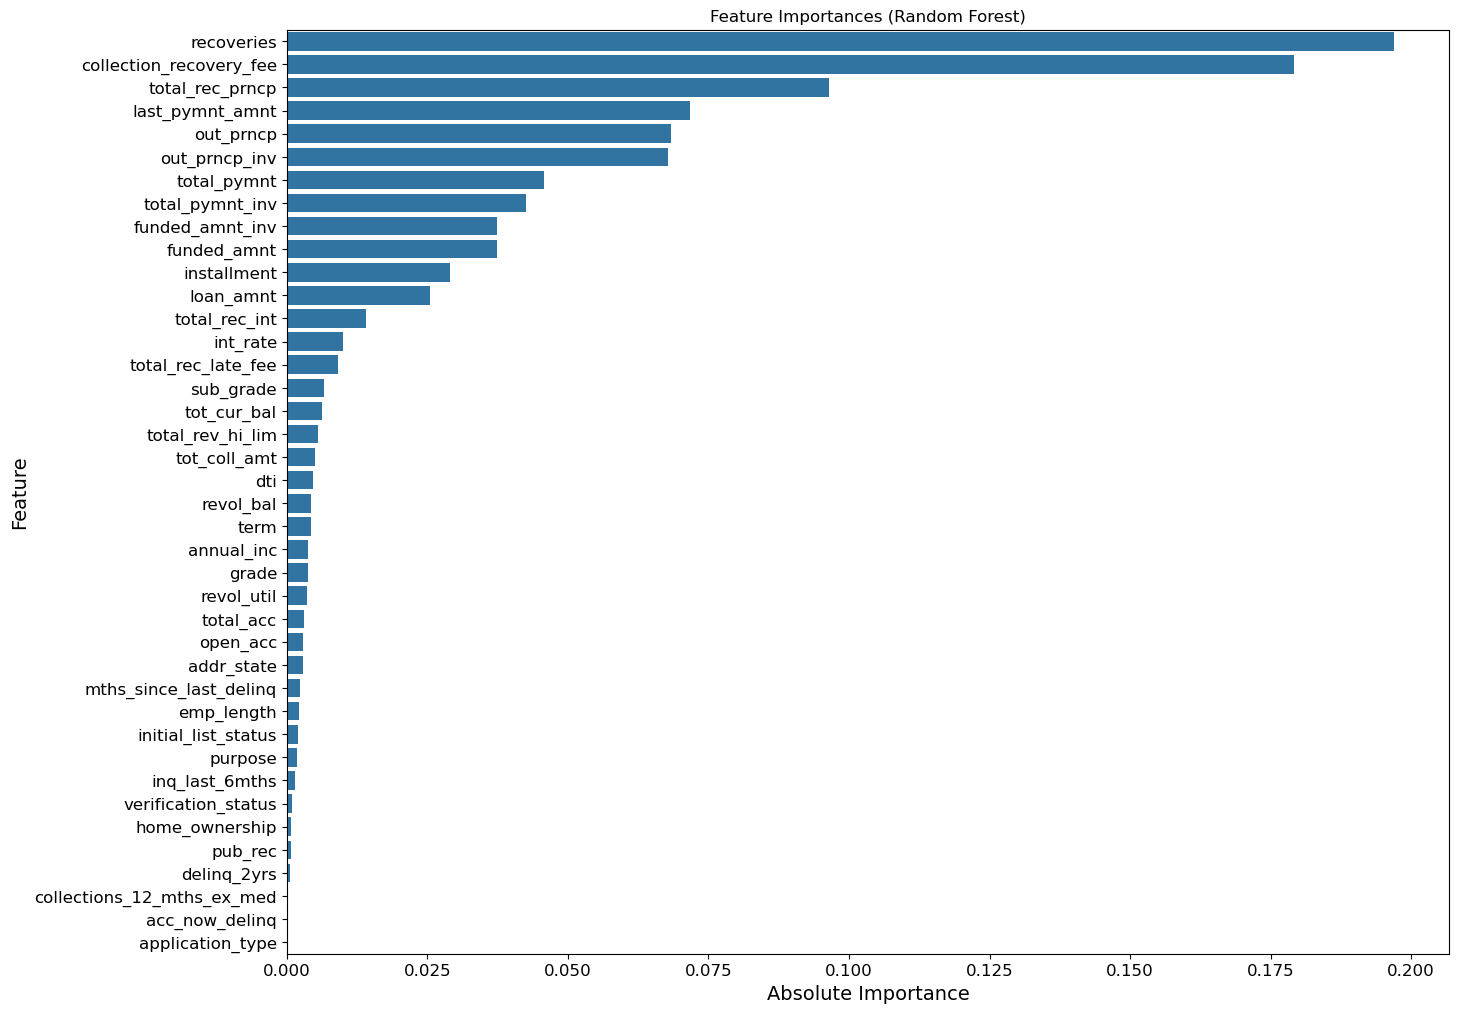


Training Set Evaluation Metrics:
Confusion Matrix:
[[48570     0]
 [    2  2786]]
Accuracy: 1.000
Precision: 1.000
Recall: 0.999
F1 Score: 1.000
Specificity: 1.000
ROC AUC: 1.000
Mean Squared Error (MSE): 0.000

Test Set Evaluation Metrics:
Confusion Matrix:
[[32352    28]
 [  132  1727]]
Accuracy: 0.995
Precision: 0.984
Recall: 0.929
F1 Score: 0.956
Specificity: 0.999
ROC AUC: 0.988
Mean Squared Error (MSE): 0.005


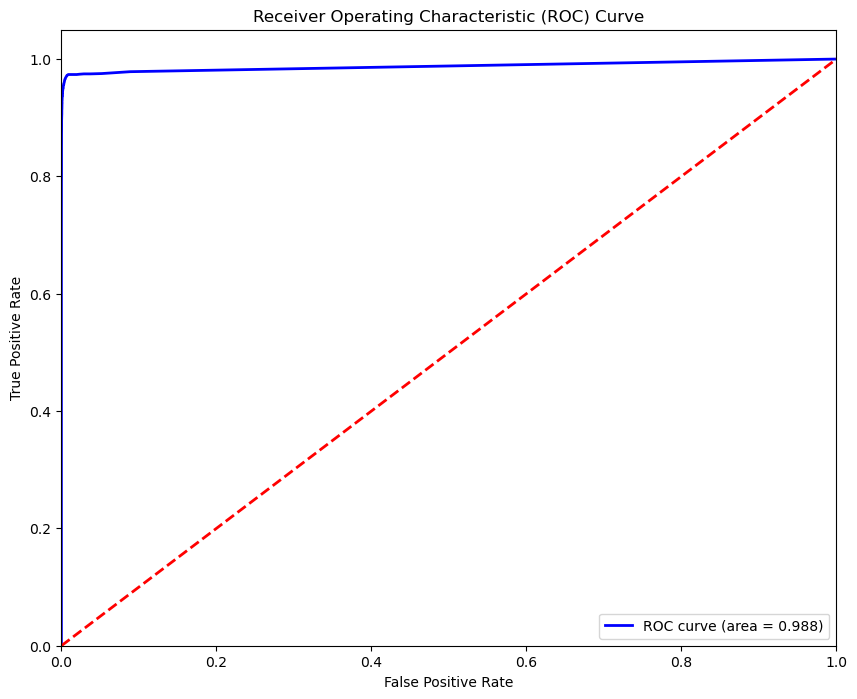


Comparison of Training and Testing Performance:
Training Accuracy: 1.000 vs Testing Accuracy: 0.995
Training Precision: 1.000 vs Testing Precision: 0.984
Training Recall: 0.999 vs Testing Recall: 0.929
Training F1 Score: 1.000 vs Testing F1 Score: 0.956
Training Specificity: 1.000 vs Testing Specificity: 0.999
Training ROC AUC: 1.000 vs Testing ROC AUC: 0.988
Training MSE: 0.000 vs Testing MSE: 0.005


In [19]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Apply Target encoding
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
encoder = ce.TargetEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Train the Random Forest model
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(imputer.fit_transform(X_train_encoded), y_train)

# Get feature importances
feature_importances = clf_rf.feature_importances_

# Create a DataFrame for visualization
features = X_train_encoded.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df['Absolute Importance'] = importances_df['Importance'].abs()
importances_df = importances_df.sort_values(by='Absolute Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Importance', y='Feature', data=importances_df)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Absolute Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

# Train a Random Forest model on top features
clf_rf_top = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_top.fit(imputer.fit_transform(X_train_top), y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_rf_top.predict_proba(imputer.transform(X_train_top))[:, 1]
y_train_pred = clf_rf_top.predict(imputer.transform(X_train_top))

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_rf_top.predict_proba(imputer.transform(X_test_top))[:, 1]
y_pred = clf_rf_top.predict(imputer.transform(X_test_top))

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Random Forest Model Using Top Features With Weight of Evidence Encoder

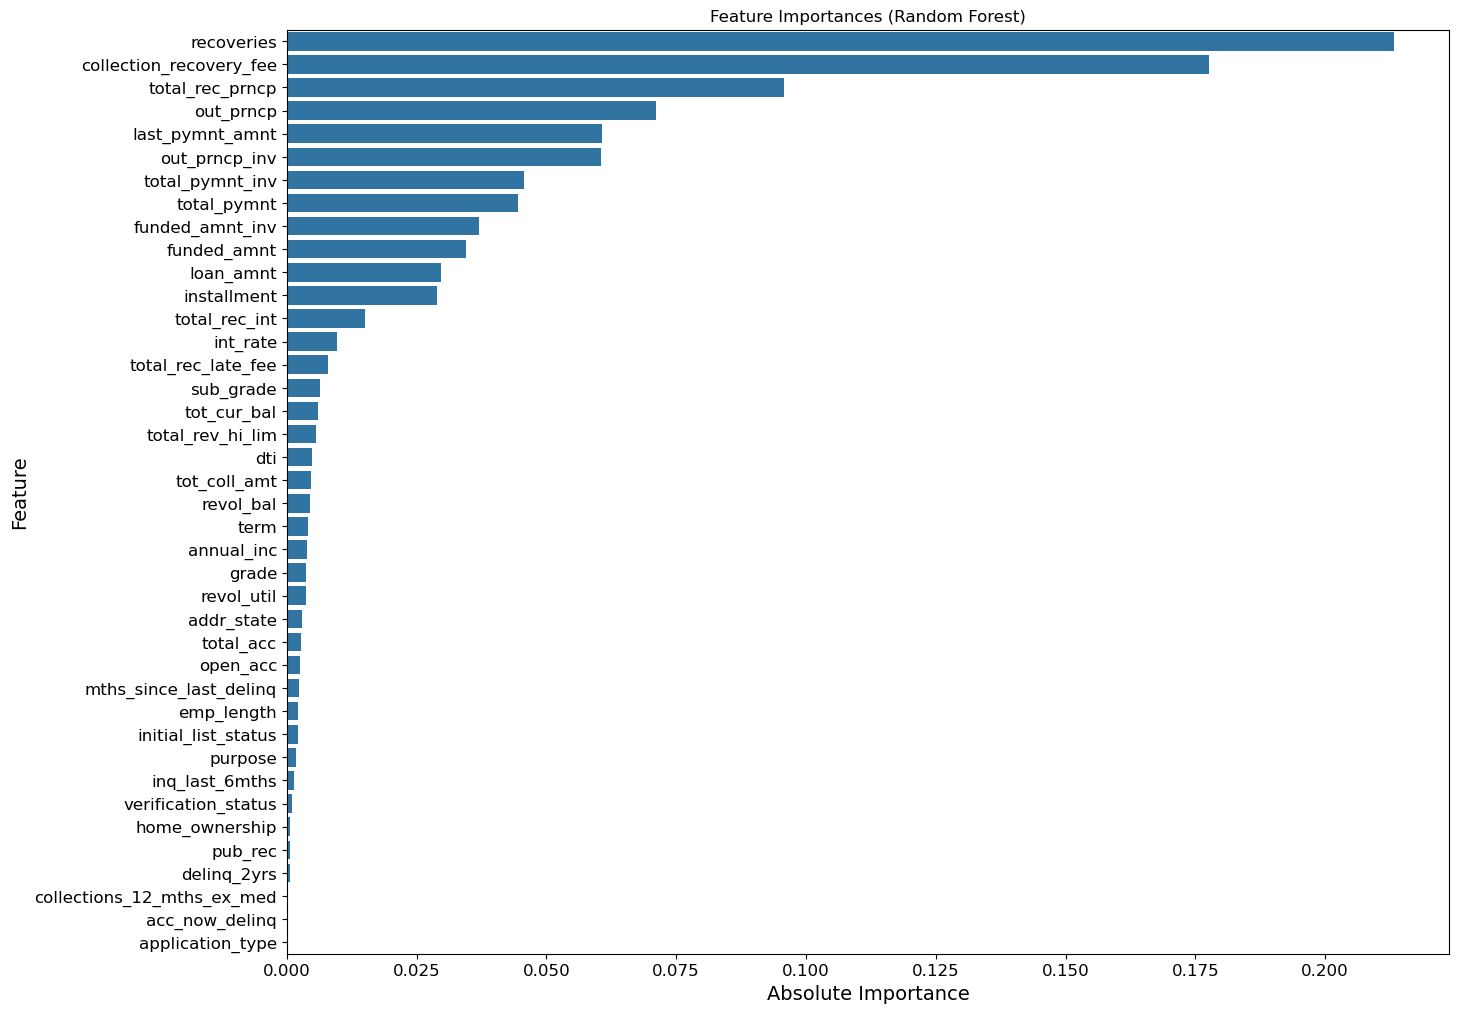


Training Set Evaluation Metrics:
Confusion Matrix:
[[48570     0]
 [    2  2786]]
Accuracy: 1.000
Precision: 1.000
Recall: 0.999
F1 Score: 1.000
Specificity: 1.000
ROC AUC: 1.000
Mean Squared Error (MSE): 0.000

Test Set Evaluation Metrics:
Confusion Matrix:
[[32347    33]
 [  130  1729]]
Accuracy: 0.995
Precision: 0.981
Recall: 0.930
F1 Score: 0.955
Specificity: 0.999
ROC AUC: 0.988
Mean Squared Error (MSE): 0.005


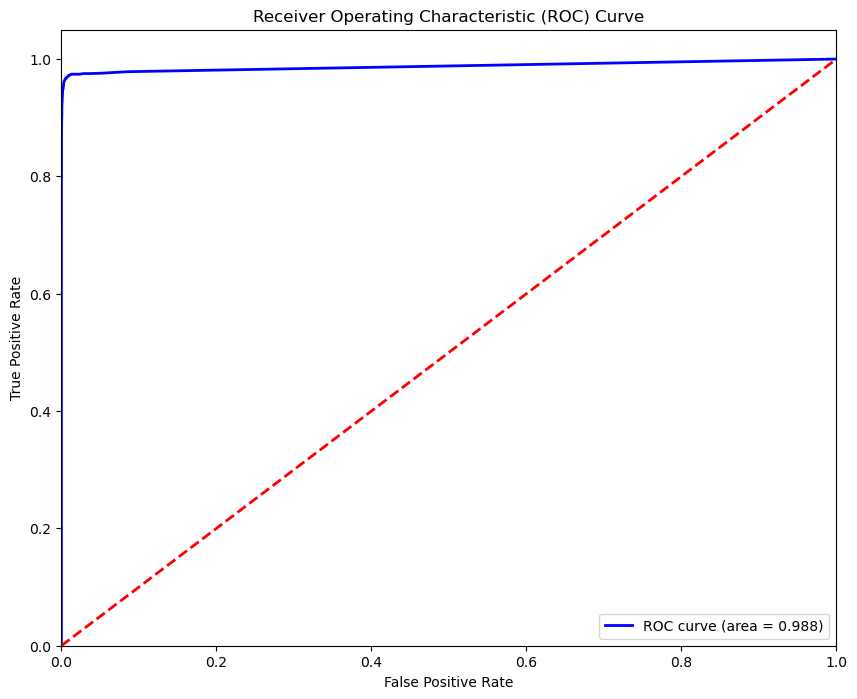


Comparison of Training and Testing Performance:
Training Accuracy: 1.000 vs Testing Accuracy: 0.995
Training Precision: 1.000 vs Testing Precision: 0.981
Training Recall: 0.999 vs Testing Recall: 0.930
Training F1 Score: 1.000 vs Testing F1 Score: 0.955
Training Specificity: 1.000 vs Testing Specificity: 0.999
Training ROC AUC: 1.000 vs Testing ROC AUC: 0.988
Training MSE: 0.000 vs Testing MSE: 0.005


In [20]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Apply WoE encoding
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
encoder = ce.WOEEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Train the Random Forest model
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(imputer.fit_transform(X_train_encoded), y_train)

# Get feature importances
feature_importances = clf_rf.feature_importances_

# Create a DataFrame for visualization
features = X_train_encoded.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df['Absolute Importance'] = importances_df['Importance'].abs()
importances_df = importances_df.sort_values(by='Absolute Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Importance', y='Feature', data=importances_df)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Absolute Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

# Train a Random Forest model on top features
clf_rf_top = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_top.fit(imputer.fit_transform(X_train_top), y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_rf_top.predict_proba(imputer.transform(X_train_top))[:, 1]
y_train_pred = clf_rf_top.predict(imputer.transform(X_train_top))

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_rf_top.predict_proba(imputer.transform(X_test_top))[:, 1]
y_pred = clf_rf_top.predict(imputer.transform(X_test_top))

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


# Random Forest Model Using Top Features With Binary Encoder

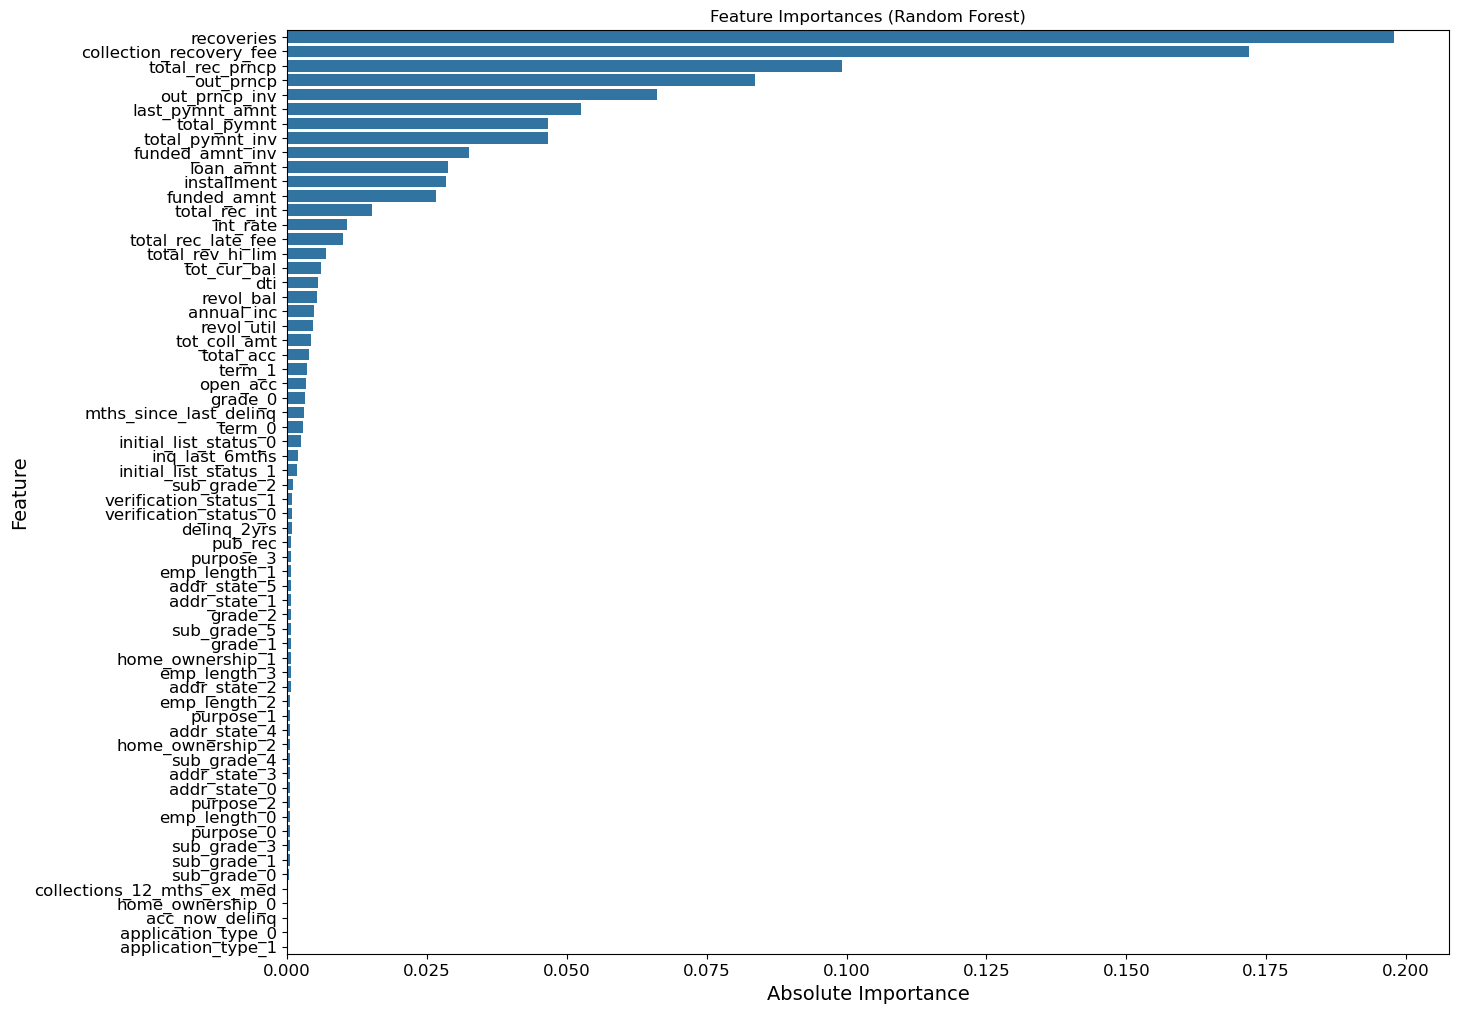


Training Set Evaluation Metrics:
Confusion Matrix:
[[48570     0]
 [    2  2786]]
Accuracy: 1.000
Precision: 1.000
Recall: 0.999
F1 Score: 1.000
Specificity: 1.000
ROC AUC: 1.000
Mean Squared Error (MSE): 0.000

Test Set Evaluation Metrics:
Confusion Matrix:
[[32355    25]
 [  132  1727]]
Accuracy: 0.995
Precision: 0.986
Recall: 0.929
F1 Score: 0.957
Specificity: 0.999
ROC AUC: 0.988
Mean Squared Error (MSE): 0.005


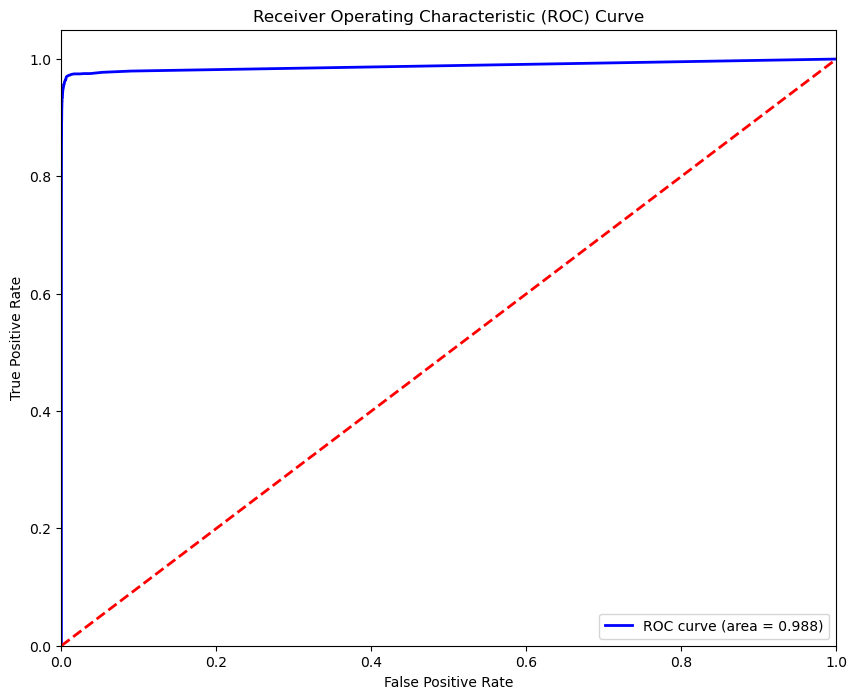


Comparison of Training and Testing Performance:
Training Accuracy: 1.000 vs Testing Accuracy: 0.995
Training Precision: 1.000 vs Testing Precision: 0.986
Training Recall: 0.999 vs Testing Recall: 0.929
Training F1 Score: 1.000 vs Testing F1 Score: 0.957
Training Specificity: 1.000 vs Testing Specificity: 0.999
Training ROC AUC: 1.000 vs Testing ROC AUC: 0.988
Training MSE: 0.000 vs Testing MSE: 0.005


In [21]:
# Define features and target
X = df5.drop(columns=['default_ind'])
y = df5['default_ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Apply Binary encoding
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
encoder = ce.BinaryEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Train the Random Forest model
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(imputer.fit_transform(X_train_encoded), y_train)

# Get feature importances
feature_importances = clf_rf.feature_importances_

# Create a DataFrame for visualization
features = X_train_encoded.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df['Absolute Importance'] = importances_df['Importance'].abs()
importances_df = importances_df.sort_values(by='Absolute Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Absolute Importance', y='Feature', data=importances_df)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Absolute Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pick the top features
top_features = importances_df.head(8)['Feature'].values
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

# Train a Random Forest model on top features
clf_rf_top = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_top.fit(imputer.fit_transform(X_train_top), y_train)

# Predict probabilities and classes on the training set
y_train_pred_proba = clf_rf_top.predict_proba(imputer.transform(X_train_top))[:, 1]
y_train_pred = clf_rf_top.predict(imputer.transform(X_train_top))

# Calculate evaluation metrics on the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_mse = mean_squared_error(y_train, y_train_pred)

# Print evaluation metrics on the training set
print("\nTraining Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"ROC AUC: {train_roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {train_mse:.3f}")

# Predict probabilities and classes on the test set
y_pred_proba = clf_rf_top.predict_proba(imputer.transform(X_test_top))[:, 1]
y_pred = clf_rf_top.predict(imputer.transform(X_test_top))

# Calculate evaluation metrics on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics on the test set
print("\nTest Set Evaluation Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compare training and testing performance
print("\nComparison of Training and Testing Performance:")
print(f'Training Accuracy: {train_accuracy:.3f} vs Testing Accuracy: {accuracy:.3f}')
print(f'Training Precision: {train_precision:.3f} vs Testing Precision: {precision:.3f}')
print(f'Training Recall: {train_recall:.3f} vs Testing Recall: {recall:.3f}')
print(f'Training F1 Score: {train_f1:.3f} vs Testing F1 Score: {f1:.3f}')
print(f'Training Specificity: {train_specificity:.3f} vs Testing Specificity: {specificity:.3f}')
print(f'Training ROC AUC: {train_roc_auc:.3f} vs Testing ROC AUC: {roc_auc:.3f}')
print(f'Training MSE: {train_mse:.3f} vs Testing MSE: {mse:.3f}')


In [25]:
import pandas as pd

# Assuming the results are stored in dictionaries
results = {
    'Logistic Regression': {
        'Label Encoder': {'Accuracy': 0.974, 'Precision': 1.000, 'Recall': 0.519, 'F1 Score': 0.683, 'Specificity': 1.000, 'ROC AUC': 0.877, 'MSE': 0.026},
        'One-Hot Encoder': {'Accuracy': 0.995, 'Precision': 0.992, 'Recall': 0.920, 'F1 Score': 0.955, 'Specificity': 1.000, 'ROC AUC': 0.991, 'MSE': 0.005},
        'Frequency Encoder': {'Accuracy': 0.974, 'Precision': 0.999, 'Recall': 0.522, 'F1 Score': 0.686, 'Specificity': 1.000, 'ROC AUC': 0.886, 'MSE': 0.026},
        'Weight of Evidence': {'Accuracy': 0.974, 'Precision': 0.998, 'Recall': 0.522, 'F1 Score': 0.686, 'Specificity': 1.000, 'ROC AUC': 0.878, 'MSE': 0.026},
        'Target Encoder': {'Accuracy': 0.974, 'Precision': 0.998, 'Recall': 0.522, 'F1 Score': 0.686, 'Specificity': 1.000, 'ROC AUC': 0.878, 'MSE': 0.026},
        'Binary Encoder': {'Accuracy': 0.974, 'Precision': 0.998, 'Recall': 0.522, 'F1 Score': 0.686, 'Specificity': 1.000, 'ROC AUC': 0.878, 'MSE': 0.026}
    },
    'Random Forest': {
        'Label Encoder': {'Accuracy': 0.995, 'Precision': 0.984, 'Recall': 0.931, 'F1 Score': 0.957, 'Specificity': 0.999, 'ROC AUC': 0.987, 'MSE': 0.005},
        'One-Hot Encoder': {'Accuracy': 0.997, 'Precision': 0.998, 'Recall': 0.950, 'F1 Score': 0.974, 'Specificity': 1.000, 'ROC AUC': 0.990, 'MSE': 0.003},
        'Frequency Encoder': {'Accuracy': 0.996, 'Precision': 0.986, 'Recall': 0.931, 'F1 Score': 0.957, 'Specificity': 0.999, 'ROC AUC': 0.989, 'MSE': 0.004},
        'Weight of Evidence': {'Accuracy': 0.995, 'Precision': 0.981, 'Recall': 0.930, 'F1 Score': 0.955, 'Specificity': 0.999, 'ROC AUC': 0.988, 'MSE': 0.005},
        'Target Encoder': {'Accuracy': 0.995, 'Precision': 0.984, 'Recall': 0.929, 'F1 Score': 0.956, 'Specificity': 0.999, 'ROC AUC': 0.988, 'MSE': 0.005},
        'Binary Encoder': {'Accuracy': 0.995, 'Precision': 0.986, 'Recall': 0.929, 'F1 Score': 0.957, 'Specificity': 0.999, 'ROC AUC': 0.988, 'MSE': 0.005}
    }
}

# Initialize a list to hold the aggregated results
aggregated_results = []

# Loop through the results dictionary to structure the data for the DataFrame
for model, encoders in results.items():
    for encoder, metrics in encoders.items():
        aggregated_results.append({
            'Model': model,
            'Encoding Method': encoder,
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1 Score': metrics['F1 Score'],
            'Specificity': metrics['Specificity'],
            'ROC AUC': metrics['ROC AUC'],
            'MSE': metrics['MSE']
        })

# Create a DataFrame from the aggregated results
df_results = pd.DataFrame(aggregated_results)

# Display the DataFrame
print(df_results)


                  Model     Encoding Method  Accuracy  Precision  Recall  \
0   Logistic Regression       Label Encoder     0.974      1.000   0.519   
1   Logistic Regression     One-Hot Encoder     0.995      0.992   0.920   
2   Logistic Regression   Frequency Encoder     0.974      0.999   0.522   
3   Logistic Regression  Weight of Evidence     0.974      0.998   0.522   
4   Logistic Regression      Target Encoder     0.974      0.998   0.522   
5   Logistic Regression      Binary Encoder     0.974      0.998   0.522   
6         Random Forest       Label Encoder     0.995      0.984   0.931   
7         Random Forest     One-Hot Encoder     0.997      0.998   0.950   
8         Random Forest   Frequency Encoder     0.996      0.986   0.931   
9         Random Forest  Weight of Evidence     0.995      0.981   0.930   
10        Random Forest      Target Encoder     0.995      0.984   0.929   
11        Random Forest      Binary Encoder     0.995      0.986   0.929   

    F1 Scor

# Insights

Label encoding assigns a unique integer to each category in a categorical feature. For example, if you have a feature "color" with categories "red", "green", "blue", the encoder might assign 0 to "red", 1 to "green", and 2 to "blue".
Benefits: Simple and efficient, Can be useful for categories that have a natural order.
Drawbacks: Introduces an implicit ordinal relationship between categories, which may not exist

One-hot encoding converts each category in a categorical feature into a separate binary feature (column) that indicates the presence or absence of that category. 
Benefits: Prevents the model from assuming any ordinal relationship between categories.
Drawbacks: Increases the dimensionality of the data

Frequency encoding replaces each category in a categorical feature with the frequency (count) of that category. For example, if "red" appears 50 times, "green" 30 times, and "blue" 20 times, the encoded values would be 50, 30, and 20 respectively.
Benefits: Maintains the distribution of categories and introduces a pseudo-ordinal relationship based on frequency.
Drawbacks: In linear models like Logistic Regression, this might still cause some bias towards more frequent categories, potentially impacting the model's interpretability.

Weight of Evidence encoding calculates the log odds of the target variable for each category. 
Benefits: Transforms categorical variables in a way that incorporates information about the target variable, which can improve model performance.
Drawbacks: Can be complex to calculate and requires the target variable during the encoding process, making it less suitable for certain validation and real-time scenarios.

Target encoding replaces each category with the mean of the target variable for that category. For instance, if the average target value for "red" is 0.8, "green" is 0.5, and "blue" is 0.2, those are the values used.
Benefits: Captures the relationship between the categorical feature and the target variable.
Drawbacks: Prone to overfitting, especially with high-cardinality features or when the dataset is small.

Binary encoding first applies label encoding to the categories, and then converts the integer values into binary code. Each bit in the binary code becomes a separate column. For instance, if "red" is 1 (binary 001), "green" is 2 (binary 010), and "blue" is 3 (binary 011), the encoded columns will be the binary digits.
Benefits: Reduces the dimensionality compared to one-hot encoding, especially for high-cardinality features.
Drawbacks: Can be less interpretable compared to other encoding methods.

Logistic Regression:
Best Encoding Methods: One-Hot Encoder, Target Encoder, Weight of Evidence Encoder.These usually encodings help Logistic Regression handle categorical variables more effectively by treating each category independently or incorporating meaningful information about the target variable.

Random Forest Classifier:
Best Encoding Methods: Label Encoder, Frequency Encoder, Binary Encoder, Target Encoder.
Tree-based models like Random Forest can handle various types of numerical encodings well. Frequency and Target encoders introduce meaningful numerical relationships that can enhance model performance.